# Experimentation to use VAE as prediction model

## Loading libraries

In [1]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#paths in git

#root git folder 
path_main_folder = '/home/goubetcle/Documents/CVAE/marota_cvae'
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_main_folder)
#add  to path source code folder
sys.path.append(path_main_folder+'/src')

In [3]:
#import class and methods from src
from keras import backend as K
from CVAE.callbacks import *
#from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE, CVAE_emb, CAE
from conso.load_shape_data import *  

import Visualisation.buildProjector
from Visualisation.buildProjector import *
from FeaturesScore.scoring import *
from FeaturesScore.exploration import *

#from conso.load_shape_data import get_x_conso_autoencoder
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

In [4]:
import CVAE.cvae_model
import CVAE.cvae_model_mixture
import CVAE.cvae_model_cluster
import importlib
import FeaturesScore.exploration
importlib.reload(CVAE.cvae_model)
importlib.reload(CVAE.cvae_model_mixture)
importlib.reload(CVAE.cvae_model_cluster)
importlib.reload(FeaturesScore.exploration)

%load_ext autoreload
%autoreload

Instructions for updating:
Colocations handled automatically by placer.


## Shapping the data

In [5]:
# Load dataframe
path_data = os.path.join(path_main_folder, 'data')
dataset_csv = os.path.join(path_data, "dataset_2012_2017.csv")
x_conso = pd.read_csv(dataset_csv, sep=",").rename(columns={'conso_final':'consumption_France_final'})
x_conso.ds = pd.to_datetime(x_conso.ds)
x_conso_2018 = pd.read_csv(path_data+"/dataset_2018.csv").rename(columns={'consommation_france':'consumption_France_final', 'temperature':'temperature_France', 'prev_J_1':'day_ahead'})
x_conso_2018.ds = pd.to_datetime(x_conso_2018.ds)
x_conso_2018['temperature_France'].interpolate(method='linear',inplace=True)

In [6]:
x_conso_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 5 columns):
ds                          17520 non-null datetime64[ns]
consumption_France_final    17520 non-null float64
is_holiday_day              17520 non-null int64
day_ahead                   17520 non-null float64
temperature_France          17520 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 684.5 KB


In [7]:
x_conso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87830 entries, 0 to 87829
Data columns (total 6 columns):
ds                          87830 non-null datetime64[ns]
consumption_France          87830 non-null float64
temperature_France          87830 non-null float64
is_holiday_day              87830 non-null float64
consumption_France_final    87830 non-null float64
day_ahead                   87830 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.0 MB


In [8]:
name_set_plot = 'train'
version = '-v1'
nPoints=1830

In [9]:
dict_xconso = {'train': x_conso[['ds','consumption_France_final', 'temperature_France', 'is_holiday_day', 'day_ahead']], 'test':x_conso_2018[['ds','consumption_France_final', 'temperature_France', 'is_holiday_day', 'day_ahead']]}

In [10]:
# Normalize input variables
dict_xconso, scaler = normalize_xconso(dict_xconso, type_scaler = 'standard')

['consumption_France_final']


In [11]:
dict_xconso['train'].describe()

consumption_France_final  temperature_France  is_holiday_day  \
count              8.783000e+04        87830.000000    87830.000000   
mean              -2.588793e-18           12.639393        0.030058   
std                1.000006e+00            6.706958        0.170748   
min               -2.085285e+00           -4.714150        0.000000   
25%               -7.620740e-01            7.452313        0.000000   
50%               -1.347014e-01           12.238112        0.000000   
75%                7.029703e-01           17.484106        0.000000   
max                3.316839e+00           33.451400        1.000000   

          day_ahead  
count  87830.000000  
mean   54170.372971  
std    11903.442325  
min    28500.000000  
25%    45100.000000  
50%    52600.000000  
75%    62400.000000  
max    95100.000000

In [12]:
for key in dict_xconso.keys():
    dict_xconso[key].day_ahead = scaler.transform(dict_xconso[key].day_ahead.values.reshape(-1,1))

In [13]:
for key in dict_xconso.keys():
    dict_xconso[key]["season"] = np.ones_like(dict_xconso[key]['ds'].dt.month.values) *3
    dict_xconso[key]['season'].iloc[np.where((dict_xconso[key]['ds'].dt.month == 10) + (dict_xconso[key]['ds'].dt.month == 4) + ((dict_xconso[key]['ds'].dt.month == 5) * (dict_xconso[key]['ds'].dt.day <= 25)))] = 2
    dict_xconso[key]['season'].iloc[np.where((dict_xconso[key]['ds'].dt.month <= 3) + (dict_xconso[key]['ds'].dt.month >= 11))] = 1                        
                    

In [14]:
dict_xconso['train'].describe()

consumption_France_final  temperature_France  is_holiday_day  \
count              8.783000e+04        87830.000000    87830.000000   
mean              -2.588793e-18           12.639393        0.030058   
std                1.000006e+00            6.706958        0.170748   
min               -2.085285e+00           -4.714150        0.000000   
25%               -7.620740e-01            7.452313        0.000000   
50%               -1.347014e-01           12.238112        0.000000   
75%                7.029703e-01           17.484106        0.000000   
max                3.316839e+00           33.451400        1.000000   

          day_ahead        season  
count  87830.000000  87830.000000  
mean      -0.025392      1.934533  
std        0.992972      0.872195  
min       -2.166786      1.000000  
25%       -0.782032      1.000000  
50%       -0.156390      2.000000  
75%        0.661115      3.000000  
max        3.388913      3.000000

In [15]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso)
list_cond = ['day','weekday', 'temperature', 'month', 'holiday']
dataset_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=list_cond)

day (1830, 7)
weekday (1830, 1)
temperature (1830, 48)
month (1830, 12)
holiday (1830, 1)
day (365, 7)
weekday (365, 1)
temperature (365, 48)
month (365, 12)
holiday (365, 1)


In [16]:
dataset_temp = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=['temperature', 'season'])

temperature (1830, 48)
season (1830, 3)
temperature (365, 48)
season (365, 3)


In [17]:
dataset_all_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=['day','weekday', 'month', 'temperature', 'season'])

day (1830, 7)
weekday (1830, 1)
month (1830, 12)
temperature (1830, 48)
season (1830, 3)
day (365, 7)
weekday (365, 1)
month (365, 12)
temperature (365, 48)
season (365, 3)


In [18]:
dataset_all_cond_emb, to_emb_dim = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=['day','weekday', 'month', 'temperature','is_holiday','potential_bridge_holiday', 'season'], embedding=True)

day (1830, 7)
weekday (1830, 1)
month (1830, 12)
temperature (1830, 48)
is_holiday (1830, 1)
potential_bridge_holiday (1830, 1)
season (1830, 3)
8
day (365, 7)
weekday (365, 1)
month (365, 12)
temperature (365, 48)
is_holiday (365, 1)
potential_bridge_holiday (365, 1)
season (365, 3)
8


In [19]:
to_emb_dim

[7, 1, 12, 48, 1, 1, 3]

In [20]:
#importation des données calendaires
calendar_info={}
for key in dataset.keys():
    calendar_info[key] = pd.DataFrame(dataset[key]['ds'])
    calendar_info[key]['month'] = calendar_info[key].ds.dt.month
    calendar_info[key]['weekday'] = calendar_info[key].ds.dt.weekday
    calendar_info[key]['is_weekday'] = (calendar_info[key].weekday < 5).apply(lambda x:int(x))
    if key == 'train':
        calendar_info[key] = pd.merge(calendar_info[key], x_conso[['ds', 'is_holiday_day']], on='ds', how ='left')
    else:
        calendar_info[key] = pd.merge(calendar_info[key], x_conso_2018[['ds', 'is_holiday_day']], on='ds', how ='left')
    
    day_hol = calendar_info[key][['weekday', 'is_holiday_day']].copy().values
    bridge_index=[]
    for i in range(day_hol.shape[0]):
        if day_hol[i,1]==1:
            if day_hol[i,0]==1:
                bridge_index.append(i-1)
            elif day_hol[i,0]==3:
                bridge_index.append(i+1)

    bridges = np.zeros(day_hol.shape[0])
    bridges[np.asarray(bridge_index)] = 1

    calendar_info[key]['potential_bridge_holiday'] = bridges
    
    calendar_info[key].loc[calendar_info[key]['is_holiday_day'].isna(),'is_holiday_day'] = 0
    calendar_info[key]['season'] = np.ones_like(calendar_info[key]['month'].values) *3
    calendar_info[key]['season'].iloc[np.where((calendar_info[key].ds.dt.month == 10) + (calendar_info[key].ds.dt.month == 4) + ((calendar_info[key].ds.dt.month == 5) * (calendar_info[key].ds.dt.day <= 25)))] = 2
    calendar_info[key]['season'].iloc[np.where((calendar_info[key].ds.dt.month <= 3) + (calendar_info[key].ds.dt.month >= 11))] = 1                        
                                    

In [21]:
calendar_info['train'].describe()

month      weekday   is_weekday  is_holiday_day  \
count  1830.000000  1830.000000  1830.000000     1830.000000   
mean      6.535519     3.003279     0.713661        0.030055   
std       3.455188     2.000817     0.452173        0.170784   
min       1.000000     0.000000     0.000000        0.000000   
25%       4.000000     1.000000     0.000000        0.000000   
50%       7.000000     3.000000     1.000000        0.000000   
75%      10.000000     5.000000     1.000000        0.000000   
max      12.000000     6.000000     1.000000        1.000000   

       potential_bridge_holiday       season  
count               1830.000000  1830.000000  
mean                   0.008743     1.934426  
std                    0.093121     0.872435  
min                    0.000000     1.000000  
25%                    0.000000     1.000000  
50%                    0.000000     2.000000  
75%                    0.000000     3.000000  
max                    1.000000     3.000000

In [22]:
#importation des données météo
meteo1_csv = os.path.join(path_data, "meteo_events.csv")
meteo2_csv = os.path.join(path_data, "meteo_events_2.csv")

meteo_events1 = pd.read_csv(meteo1_csv)
meteo_events2 = pd.read_csv(meteo2_csv)
meteo_events = meteo_events1.append(meteo_events2)
events = ['snow', 'floods', 'storm', 'hurricane', 'heavy_rains', 'cold', 'hot']
meteo_records=pd.DataFrame(data=np.zeros((nPoints, len(events))), columns=events)
from datetime import *
for k in range(meteo_events.shape[0]):
    day = datetime.strptime(meteo_events.iloc[k,0],'%Y-%m-%d')
    cld = np.asarray(calendar_info['train'].ds.dt.date)
    row = np.where(cld==day.date())[0]
    meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])
    duration = int(meteo_events.iloc[k,1])
    if duration != 0:
        for i in range(duration):
            day_inc = timedelta(days=i+1)+day
            cld = np.asarray(calendar_info['train'].ds.dt.date)
            row = np.where(cld==day_inc.date())[0]
            meteo_records.iloc[row,:]+=np.asarray(meteo_events.iloc[k,2:-1])

meteo_records.iloc[:,:] = 1*(meteo_records.iloc[:,:]>0)

In [23]:
factorMatrix={}
for key in calendar_info.keys():
    if key =='train' :
        xconso = x_conso
    else:
        xconso=x_conso_2018
    factors = calendar_info[key].iloc[:,1:].copy()
    columns_x = xconso.columns
    conso_idx = np.argmax(['consumption' in c for c in xconso.columns])
    temp_idx = np.argmax(['temperature' in c for c in xconso.columns])
    dates = np.unique(xconso['ds'].dt.date)
    temperatureMean=np.asarray([np.nanmean(xconso[columns_x[temp_idx]].iloc[np.where(xconso['ds'].dt.date==dates[k])]) for k in range(dates.shape[0])])

    factorMatrix[key] = np.c_[factors.values,temperatureMean]

factorDesc={
    'month':'category',
    'weekday':'category',
    'is_weekday':'category',
    'is_holiday_day':'category',
    'is_bridge_day':'category',
    'season':'category',
    'temperature':'regressor',
}

## Tools for evaluation

In [24]:
#visualisation des metriques
def display_metrics(model_eval, z_dim, factorDesc):
    if 'reconstruction_error' in model_eval.keys():
        for k,v in model_eval['reconstruction_error'].item():
            print(k, ' : ', v)
    print('Mutual Information Gap : %.2f'%model_eval['mig'])

    fig = plt.figure(dpi=100,figsize=(10,8))

    plt.subplot(1, 3, 1)
    fig.subplots_adjust(hspace=0.5)
    plt.bar(factorDesc.keys(),model_eval['informativeness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.ylim(top=1)
    for index,data in enumerate(model_eval['informativeness']):
        plt.text(x=index - 0.5, y =data+0.01 , s="%.2f"%data , fontdict=dict(fontsize=10))
    plt.title('Informativeness score : %.2f'%np.mean(model_eval['informativeness']))

    plt.subplot(1, 3, 2)
    plt.bar(np.arange(z_dim)+1,model_eval['disentanglement'])
    plt.xlabel('latent variables')
    plt.title('Disentanglement score : %.2f'%model_eval['mean_disentanglement']);

    plt.subplot(1, 3, 3)
    plt.bar(factorDesc.keys(),model_eval['compactness'])
    plt.xlabel('factors')
    plt.xticks(rotation=75)
    plt.title('Compactness')
    plt.tight_layout();

In [25]:
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix, center=None):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,0], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,1]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,-1], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    
    if center is not None:
        proj_c = proj2D.transform(center).reshape(1,-1)
        plt.scatter(x=proj_c[:,0],y=proj_c[:,1], c='black', marker='*', s= 500)

In [26]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(list_x,date,scaler,labels=None):
    if labels is None:
        labels=['truth']+['reconstruction_{}'.format(j) for j in np.arange(1,len(list_x))]
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    x = scaler.inverse_transform(list_x[0])
    x_hat = [scaler.inverse_transform(x_hat) for x_hat in list_x[1:]]
    plt.plot(x, label = labels[0])
    for j,x_hat in enumerate(x_hat):
        plt.plot(x_hat, '--', label = labels[j+1])
    plt.title(date)
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

In [27]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=1830
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

# Modèle classique

In [28]:
list_cond = ['season']
dataset_season = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=list_cond)

season (1830, 3)
season (365, 3)


In [29]:
batch_size=16
epochs = 800

In [30]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,35,24,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = dataset['train']['x'][0].shape[1]

In [31]:
# paramètres du modèle variationnel choisi

## pour l'erreur de reconstruction (entre L1 et L2)
is_L2_Loss=False

## pour le choix du prior univarié exponentiel entre 'Gaussian' et 'Laplace':
pdf_model = 'Gaussian'

## pour la régularisation de la fonction objectif : VAE classique --> beta = 1 et gamma = 0
Beta = K.variable(0.33, dtype='float32') 

InfoVAE = True #pour activer la régularisation supplémentaire InfoVAE
Gamma = K.variable(66., dtype='float32')

# Chercher les projections où identifier les profils similaires

## Modèle Modes-VAE

In [40]:
#charger le modèle déjà entrainé si besoin
name_model = 'cvae_modal'
log_dir_projector=path_main_folder+"/notebooks/logs/Pred/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Pred/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,70,35,24,12]
z_dim=4
beta_val = 1
Beta = K.variable(beta_val, dtype='float32')
model_CVAE_mode = CVAE.cvae_model_mixture.CVAE_modal(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1, alpha=K.variable(5., dtype='float32'),
                                beta=Beta,is_L2_Loss=False, 
                                prior_mu=np.zeros(8),        
                                name=name_model, output=path_out)

L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 49086       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0           encoder[1][3]

In [41]:
tensorboard = TensorBoard(log_dir="logs/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info['train'])


In [42]:
training = False
if training:
    model_CVAE_mode.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard, out_batch],validation_split=0.1)
else:
    model_CVAE_mode.load_model(os.path.join(path_out, name_model, 'models'))

Mutual Information Gap : 0.24


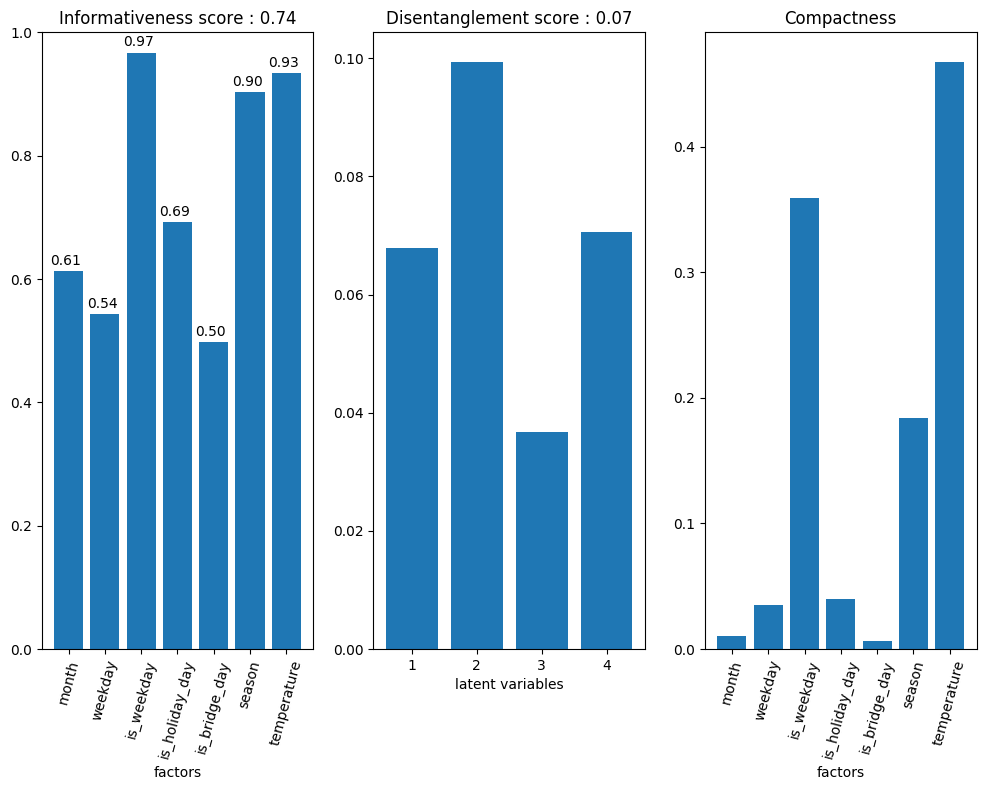

In [43]:
input_encoder = dataset['train']['x']
x_train_encoded_mode, _,variance,z_y = model_CVAE_mode.encoder.predict(input_encoder)
variance_train_mode= np.sum(np.tile(z_y.reshape(-1,1,8), (1,z_dim,1))*np.exp(variance), axis=-1)
    
input_encoder = dataset['test']['x']
x_test_encoded_mode,_, variance,z_y = model_CVAE_mode.encoder.predict(input_encoder)
variance_test_mode= np.sum(np.tile(z_y.reshape(-1,1,8), (1,z_dim,1))*np.exp(variance), axis=-1)
    
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded_mode, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

In [44]:
z_y.shape

(1830, 8)

1.279436631494812


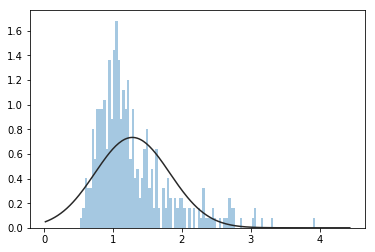

In [167]:
x_hat = model_CVAE_mode.cvae.predict(input_encoder)[0]
mae_error = np.sum(np.abs((dataset['test']['x'][0] - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((dataset['test']['x'][0] - x_hat)**2, axis=1)) / 48
#faire un histogramme des écarts
sn.distplot(mae_error, kde=False, fit=stats.norm, bins=100)
print(np.mean(mae_error))

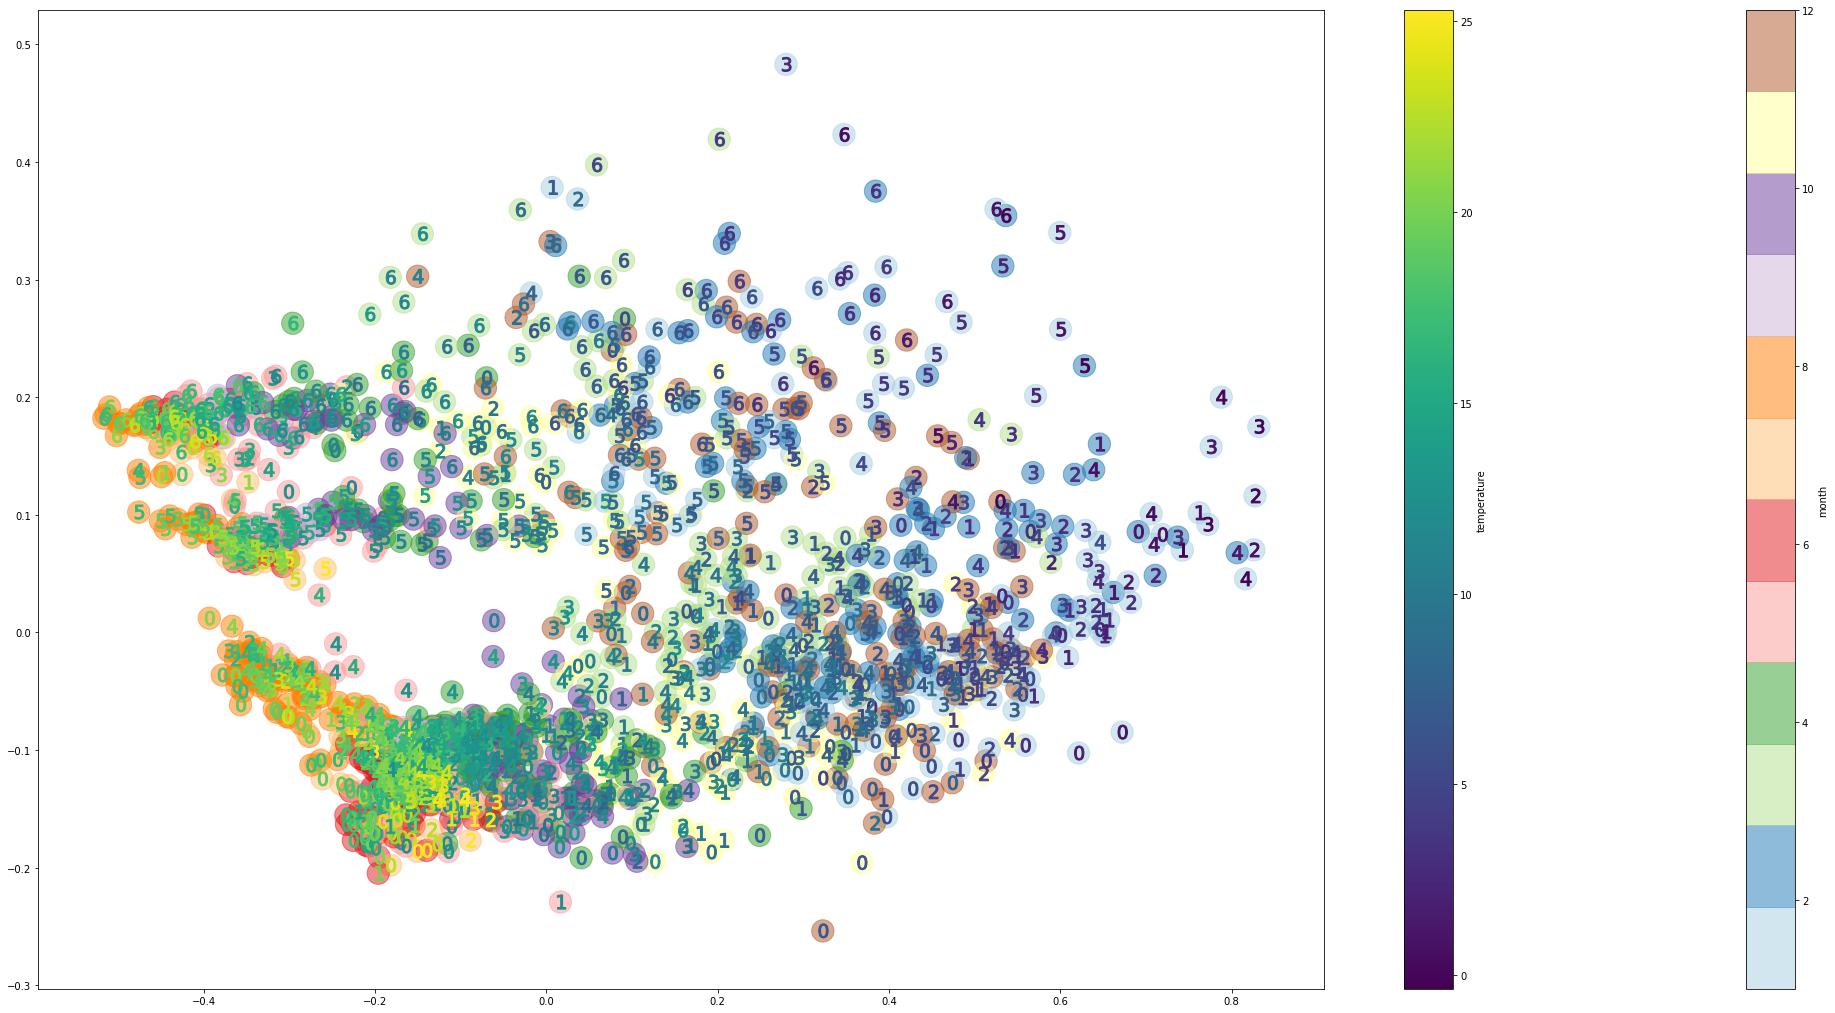

In [166]:
prez_2D(x_train_encoded_mode, factorMatrix['train'])

## Modèle Info-VAE

In [44]:
name_model = 'cvae_info'
log_dir_projector=path_main_folder+"/notebooks/logs/Pred/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Pred/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
## pour la régularisation de la fonction objectif : VAE classique --> beta = 1 et gamma = 0
Beta = K.variable(0.33, dtype='float32') 

InfoVAE = True #pour activer la régularisation supplémentaire InfoVAE
Gamma = K.variable(42., dtype='float32')
Beta = K.variable(beta_val, dtype='float32')
model_infoCVAE= CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                input_dim=input_dim, cond_dim=1, alpha=K.variable(2., dtype='float32'),
                                InfoVAE=True,beta=Beta, gamma=Gamma,is_L2_Loss=False,        
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 5454        x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 4)            0        

In [45]:
tensorboard = TensorBoard(log_dir="logs/Pred{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
out_batch = NEpochLogger(x_train_data=dataset['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info['train'])


In [46]:
if training:
    model_infoCVAE.main_train(dataset, training_epochs=epochs, batch_size=batch_size, verbose=0,callbacks=[tensorboard, out_batch],validation_split=0.1)
else:
    model_infoCVAE.load_model(os.path.join(path_out, name_model, 'models'))

Mutual Information Gap : 0.15


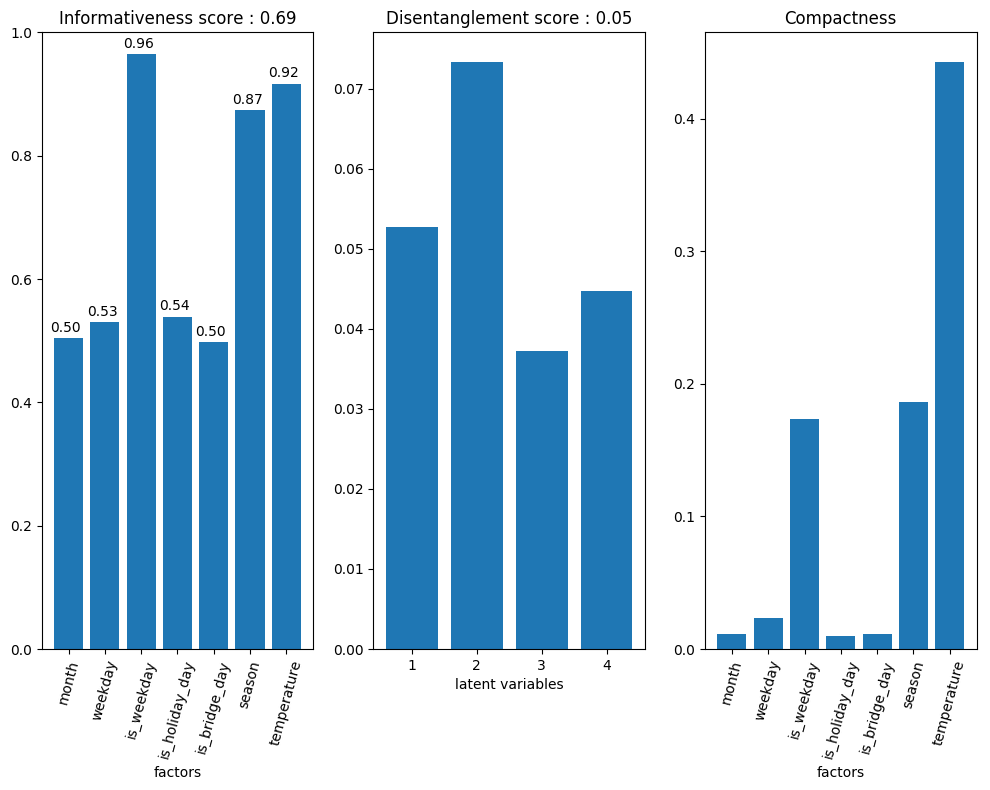

In [47]:
input_encoder = dataset['train']['x']
x_train_encoded_info, variance = model_infoCVAE.encoder.predict(input_encoder)
variance_train_info= np.exp(variance)
    
input_encoder = dataset['test']['x']
x_test_encoded_info, variance = model_infoCVAE.encoder.predict(input_encoder)
variance_test_info= np.exp(variance)
    
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded_info, factorMatrix['train'], factorDesc, orthogonalize=True)
display_metrics(model_eval, z_dim, factorDesc)

2.513976225908825


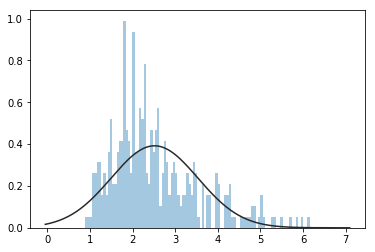

In [172]:
x_hat = model_infoCVAE.cvae.predict(input_encoder)[0]
mae_error = np.sum(np.abs((dataset['test']['x'][0] - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((dataset['test']['x'][0] - x_hat)**2, axis=1)) / 48
#faire un histogramme des écarts
sn.distplot(mae_error, kde=False, fit=stats.norm, bins=100)
print(np.mean(mae_error))

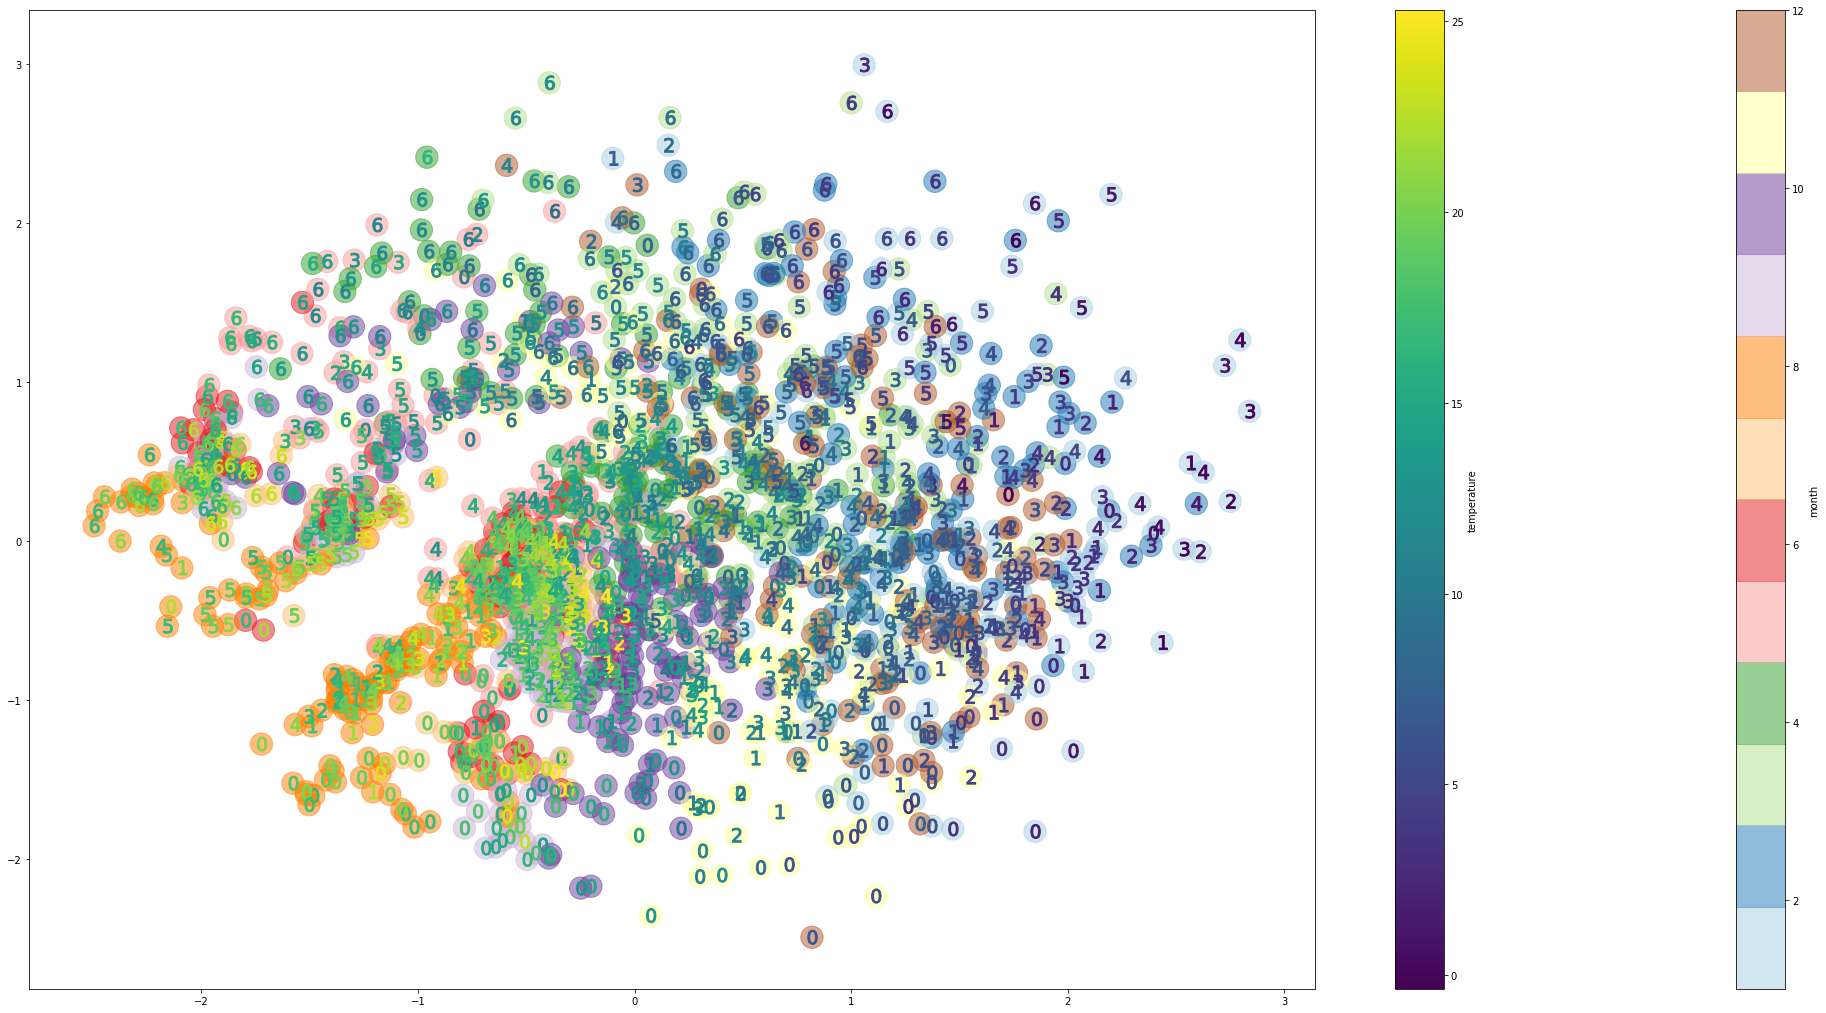

In [173]:
prez_2D(x_train_encoded_info, factorMatrix['train'])

## Modèle guided-VAE

Based on the guided-dropout idea of B.Donnot: add condition embeddings in the latent space as perturbations.
* with true signal as input, simulate sensibilities of characterization for the profile
* with prevision day ahead as input (output still being the consommation curve), simulate the possibility of making it a prevision tool.

In [48]:



dataset_guided = {}
for key in ['train', 'test']:
    temp = dataset_all_cond[key]['x'][1][:,20:68]
    dataset_guided[key] = {}
    dataset_guided[key]['x']=[dataset_all_cond[key]['x'][0],dataset_all_cond[key]['x'][1][:,:7],
                              #dataset_all_cond[key]['x'][1][:,7:8], 
                              dataset_all_cond[key]['x'][1][:,8:20],
                              np.c_[np.min(temp,axis=1)[:,np.newaxis],np.mean(temp,axis=1)[:,np.newaxis],np.max(temp,axis=1)[:,np.newaxis]],
                              calendar_info[key][['is_holiday_day','potential_bridge_holiday']].values,
                             pd.get_dummies(factorMatrix[key][:,5]).values]
    dataset_guided[key]['y'] = dataset_all_cond[key]['y']
    dataset_guided[key]['ds'] = dataset_all_cond[key]['ds']

In [49]:
input_dims = [dataset['train']['x'][0].shape[1]] + [7,12,3,2,3]

In [50]:
cond_dims = [[14,36,24,12],[12,36, 24,12], [12,36,24,12], [12,36, 24,12], [12,36, 24, 12]]
d_dims=[48,96,96,12]

import CVAE.guided_vae_model

In [51]:
name_model = 'guided_vae_L2'
log_dir_projector=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Generation/"+name_model+"/model" 
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
z_dim=4
Gamma = K.variable(8., dtype='float32')
Beta = K.variable(0.2, dtype='float32')
guided_vae = CVAE.guided_vae_model.Guided_VAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim+4, lr=lr,
                                input_dim=input_dims, cond_dims=cond_dims,InfoVAE=InfoVAE,
                                beta=Beta, gamma = Gamma, is_L2_Loss=False,       
                                name=name_model, output=path_out)

InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3)            0                                            
______________________________________________________________

In [52]:
#embeddingsMetadata = {'dec_dense_0': 'metadata.tsv'}
tensorboard = TensorBoard(log_dir="logs/Generation/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)

In [53]:
#apprentissage du modèle
 #use verbose=1 to see logs of training at every epoch
runTraining = False
if runTraining:
    guided_vae.main_train(dataset_guided, training_epochs=epochs-300, batch_size=batch_size, verbose=0,callbacks=[tensorboard],validation_split=0.2)

In [54]:
#charger le modèle déjà entrainé si besoin
load_model=1-runTraining
if load_model:
    guided_vae.load_model(os.path.join(path_out, name_model, 'models'))

In [55]:
# Récupération de la représentation latente via les distributions a posteriori des profils
input_encoder = dataset_guided['train']['x']
x_train_encoded_guided, log_sigma_train = guided_vae.encoder.predict(input_encoder)
variance_train_guided= np.exp(log_sigma_train)

input_encoder = dataset_guided['test']['x']
x_test_encoded_guided, log_sigma_test = guided_vae.encoder.predict(input_encoder)
variance_test_guided= np.exp(log_sigma_test)

0.864680264625755
Mutual Information Gap : 0.29


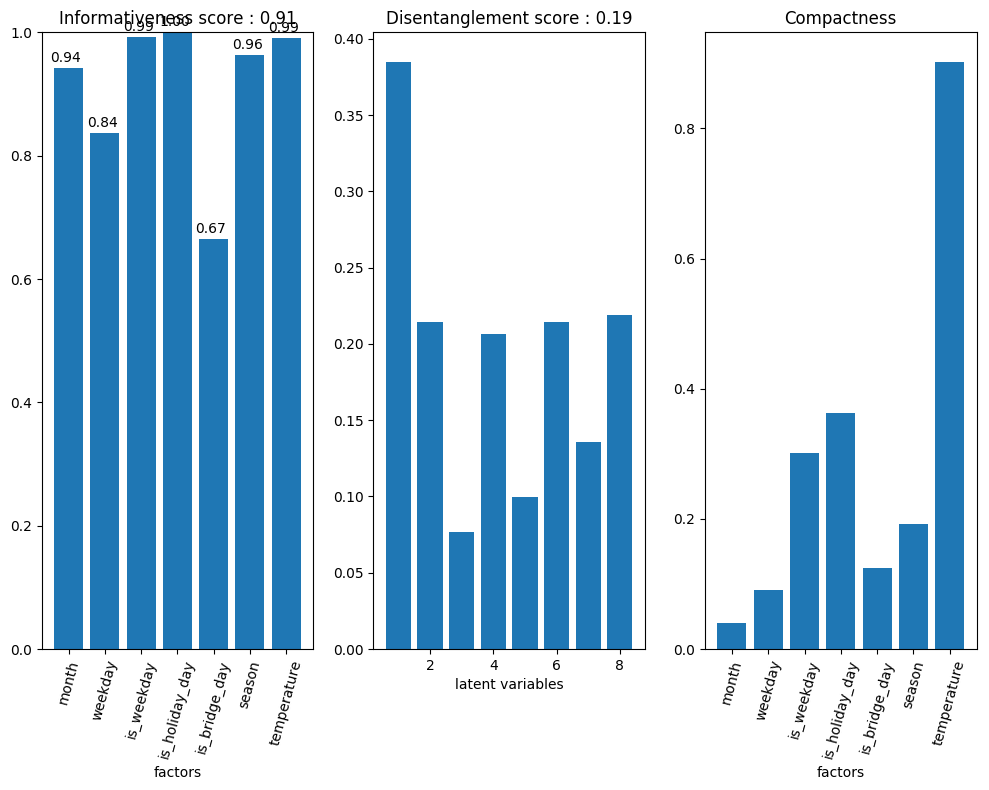

In [56]:
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded_guided, factorMatrix['train'], factorDesc, orthogonalize=True, normalize_information=True)
print(np.mean(model_eval['modularity']))
display_metrics(model_eval, (z_dim+4), factorDesc)

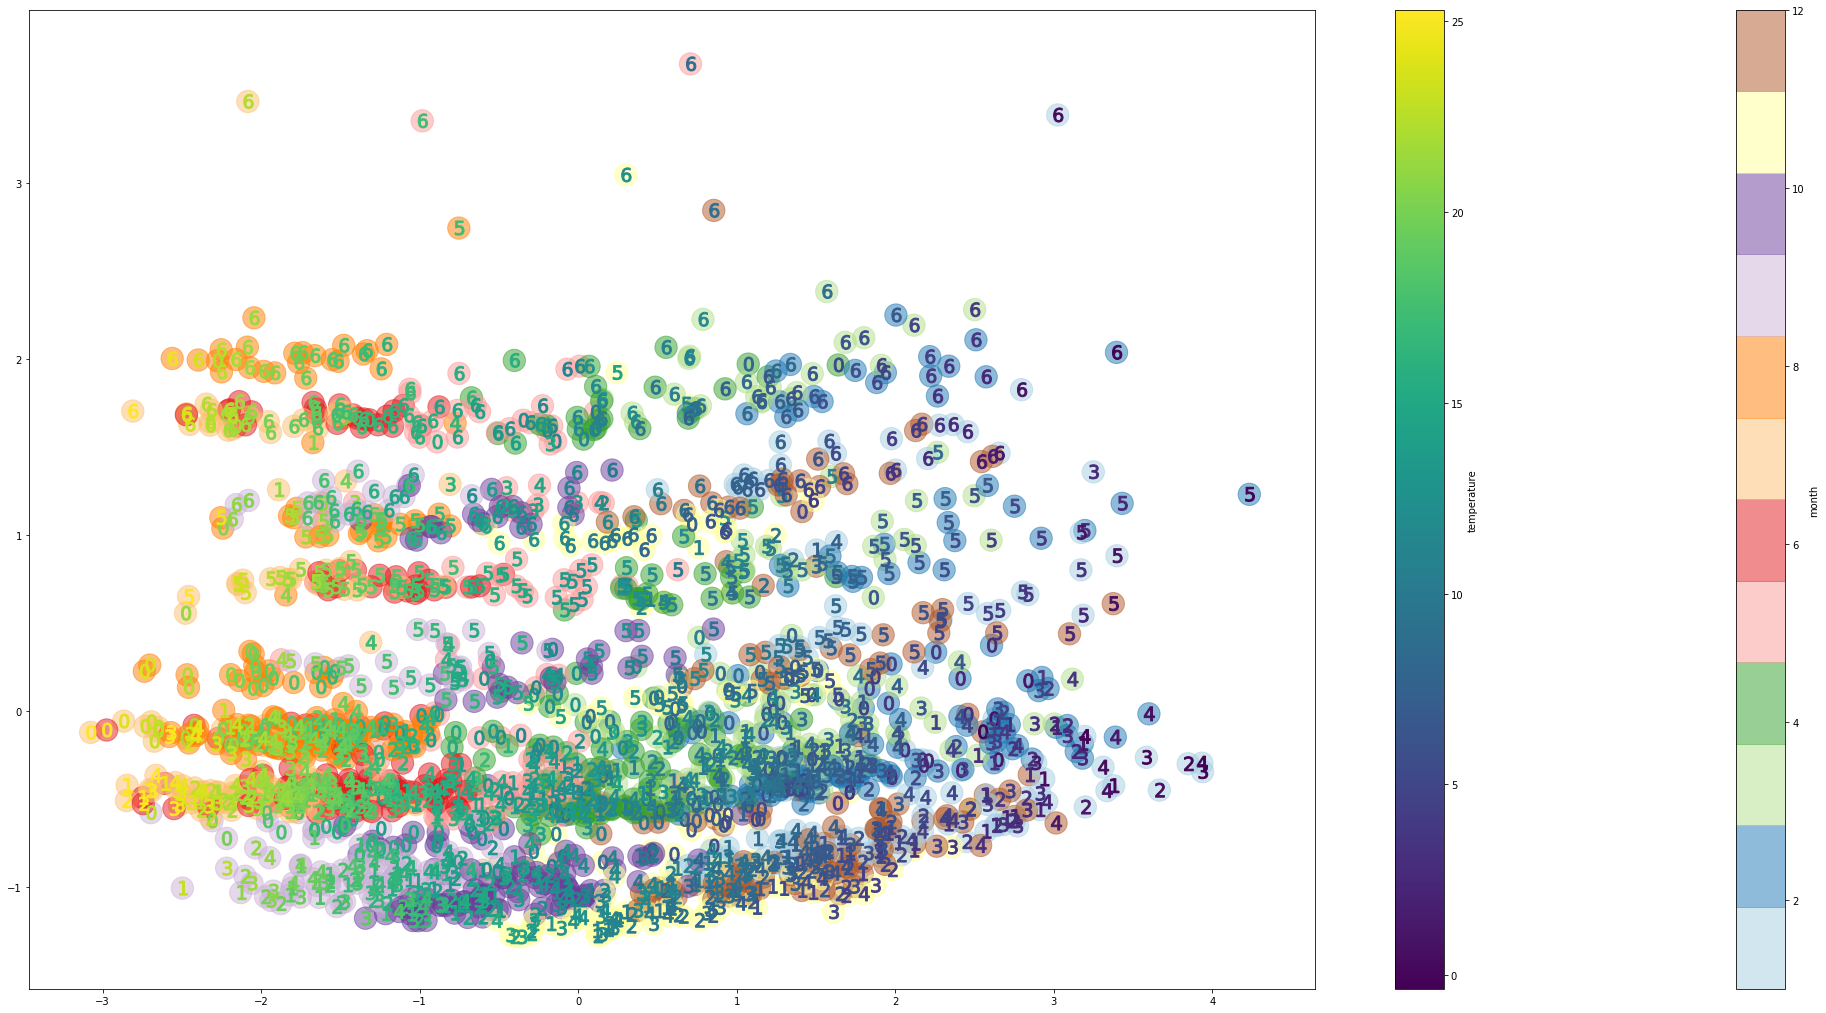

In [183]:
prez_2D(x_train_encoded_guided, factorMatrix['train'])

5.236001458060849


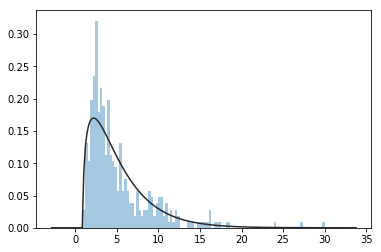

In [137]:
#calculer l'erreur de reconstruction
k=1000
list_x_hat=[]
x = dataset_guided['test']['x'][0]
for k in range(k):
    list_x_hat.append(guided_vae.cvae.predict(input_encoder)[0])
x_hat=np.mean(list_x_hat,axis=0)
mae_error = np.sum(np.abs((x - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((x - x_hat)**2, axis=1))

#faire un histogramme des écarts
sn.distplot(mae_error, kde=False, fit=stats.beta, bins=100)
print(np.mean(mae_error))

# Avoir un modèle de sampling CVAE pour avoir une faisceau de scénarios.

J'ai choisi de conditionné sur tout sauf les jours fériés pour avoir des prédictions distinctes sur ce genre de cas atypique.

In [34]:
list_cond = ['day','weekday', 'temperature', 'month']
dataset_cond = get_dataset_autoencoder(dict_xconso=dict_xconso, list_cond=list_cond)

day (1830, 7)
weekday (1830, 1)
temperature (1830, 48)
month (1830, 12)
day (365, 7)
weekday (365, 1)
temperature (365, 48)
month (365, 12)


In [51]:
#charger le modèle déjà entrainé si besoin name_model = 'cvae_all'
name_model = 'cvae_all_2'
log_dir_projector=path_main_folder+"/notebooks/logs/Pred/"+name_model+"/projector" #pour créer le dossier du projeteur tensorboard
log_dir_model=path_main_folder+"/notebooks/logs/Pred/"+name_model+"/model" #pour créer le dossier de sauvegarde du modèle
if not(os.path.isdir(log_dir_projector)):
    os.makedirs(log_dir_projector)
if not(os.path.isdir(log_dir_model)):
    os.makedirs(log_dir_model)
path_out = log_dir_model
z_dim=2
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[48,96,96,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
Beta = K.variable(0.4, dtype='float32') 

InfoVAE = True #pour activer la régularisation supplémentaire InfoVAE
Gamma = K.variable(100., dtype='float32')
model_cvae_all_cond = CVAE.cvae_model.CVAE(e_dims=e_dims, d_dims=d_dims, z_dim=z_dim, lr=lr,
                                    input_dim=input_dim, cond_dim=dataset_cond['train']['x'][1].shape[1], InfoVAE=InfoVAE,
                                    alpha=K.variable(1., dtype='float32'),beta=Beta, gamma = Gamma,  is_L2_Loss=is_L2_Loss,
                                    name=name_model, output=path_out)


InfoVAE :  True
L1 loss
False
complete model: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_true (InputLayer)             (None, 48)           0                                            
__________________________________________________________________________________________________
cond_pre (InputLayer)           (None, 68)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 13375       x_true[0][0]                     
                                                                 cond_pre[0][0]                   
__________________________________________________________________________________________________
sample_z (Lambda)               (None, 2)            0        

In [52]:
tensorboard = TensorBoard(log_dir="logs/Pred/{}".format(name_model +str(time())),write_graph=True)#,write_images=True,embeddings_freq=10, embeddings_layer_names=['dec_dense_0'],embeddings_metadata= embeddingsMetadata)
out_batch = NEpochLogger(x_train_data=dataset_cond['train']['x'], display=100,x_conso=x_conso,calendar_info=calendar_info['train'])


In [53]:
training=False
if training:
    model_cvae_all_cond.main_train(dataset_cond, training_epochs=epochs-200, batch_size=batch_size, verbose=0,callbacks=[tensorboard, out_batch],validation_split=0.1)
else:
    model_cvae_all_cond.load_model(os.path.join(path_out, name_model, 'models'))

Mutual Information Gap : 0.07


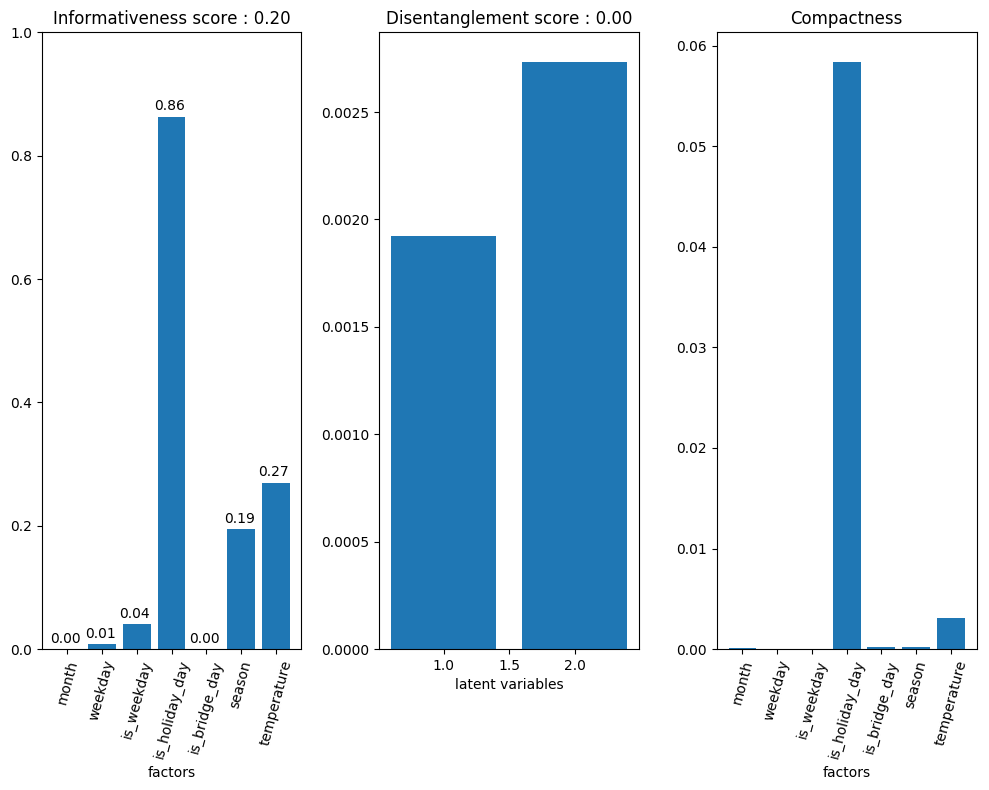

In [55]:
input_encoder = dataset_cond['train']['x']
#emb = model_cvae_all_cond.embedding_enc.predict(input_encoder[1:])
x_train_encoded_cvae, variance = model_cvae_all_cond.encoder.predict(input_encoder)
variance_train_cvae= np.exp(variance)
    
input_encoder = dataset_cond['test']['x']
#emb = model_cvae_all_cond.embedding_enc.predict(input_encoder[1:])
x_test_encoded_cvae, variance = model_cvae_all_cond.encoder.predict(input_encoder)
variance_test_cvae= np.exp(variance)
    
model_eval, importanceMatrix =evaluateLatentCode(x_train_encoded_cvae, factorMatrix['train'], factorDesc, orthogonalize=True, normalize_information=True)
display_metrics(model_eval, z_dim, factorDesc)

In [146]:
predictFeaturesInLatentSPace(x_conso,calendar_info['train'],x_train_encoded_cvae,k=5,cv=10)

12.379927265625
              is_weekday   weekday     month  is_holiday_day  temperature
score model     0.547102  0.197855  0.119096        0.763636    -0.153035
random model    0.490358  0.164971  0.088722        0.043636    -0.452239


{'dataFrame':               is_weekday   weekday     month  is_holiday_day  temperature
 score model     0.547102  0.197855  0.119096        0.763636    -0.153035
 random model    0.490358  0.164971  0.088722        0.043636    -0.452239,
 'oddWeekdays': 1      2012-12-29
 8      2013-01-05
 9      2013-01-06
 20     2013-01-17
 22     2013-01-19
 23     2013-01-20
 29     2013-01-26
 30     2013-01-27
 36     2013-02-02
 51     2013-02-17
 53     2013-02-19
 57     2013-02-23
 58     2013-02-24
 65     2013-03-03
 71     2013-03-09
 72     2013-03-10
 78     2013-03-16
 79     2013-03-17
 85     2013-03-23
 93     2013-03-31
 99     2013-04-06
 106    2013-04-13
 107    2013-04-14
 113    2013-04-20
 120    2013-04-27
 121    2013-04-28
 128    2013-05-05
 135    2013-05-12
 141    2013-05-18
 162    2013-06-08
           ...    
 1675   2017-07-30
 1684   2017-08-08
 1690   2017-08-14
 1696   2017-08-20
 1702   2017-08-26
 1703   2017-08-27
 1710   2017-09-03
 1717   2017-09-10
 1721

3.5868310851691496


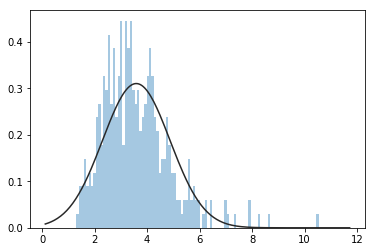

In [148]:
x_hat = model_cvae_all_cond.cvae.predict(input_encoder)[0]
mae_error = np.sum(np.abs((dataset_temp['test']['x'][0] - x_hat)),axis=1)
mse_error = np.sqrt(np.sum((dataset_temp['test']['x'][0] - x_hat)**2, axis=1))
#faire un histogramme des écarts
sn.distplot(mae_error, kde=False, fit=stats.norm, bins=100)
print(np.mean(mae_error))

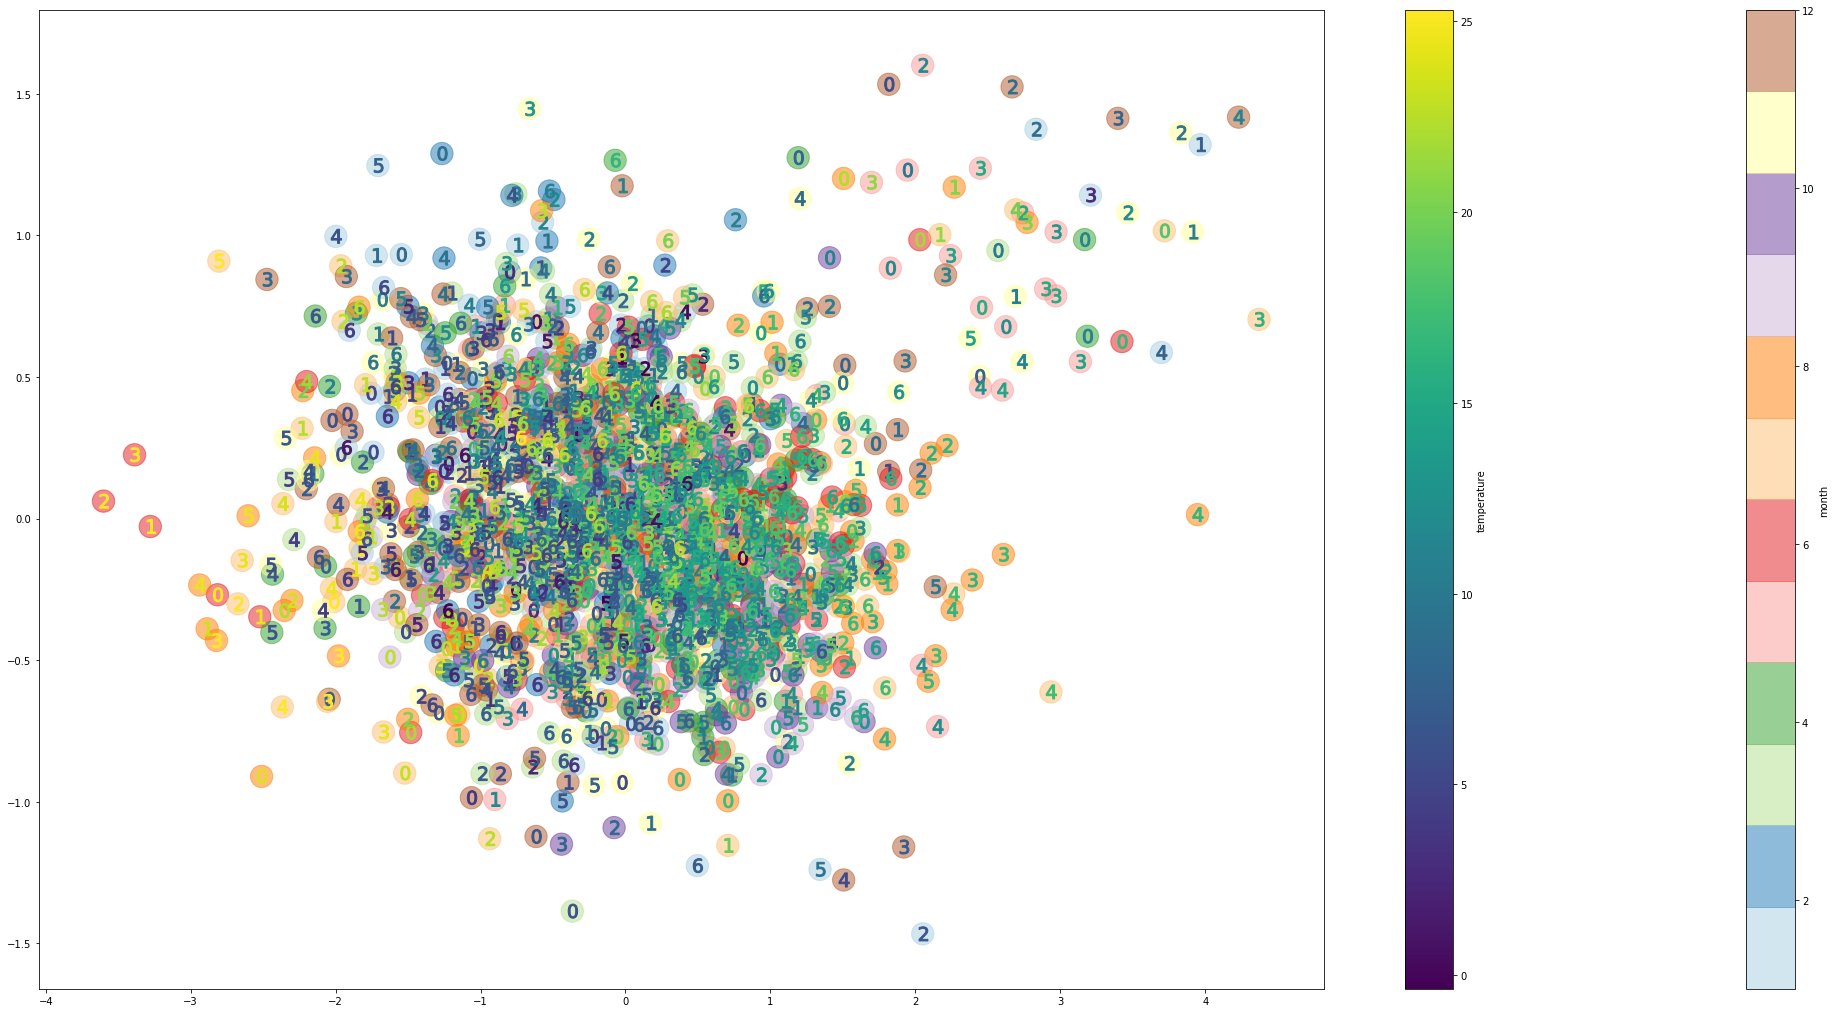

In [329]:
prez_2D(x_train_encoded_cvae, factorMatrix['train'])

### Calibration du modèle de mélange gaussien pour faire de l'échantillonnage

In [341]:
is_H = calendar_info['train']['is_holiday_day']
mean_H = np.mean(x_train_encoded_cvae[np.where(is_H==1)[0],:],axis=0)
mean_N = np.mean(x_train_encoded_cvae[np.where(is_H==0)[0],:],axis=0)
print(mean_H,'\n',mean_N)

[ 0.43397176 -2.3003552 ] 
 [-0.16511877  0.19748391]


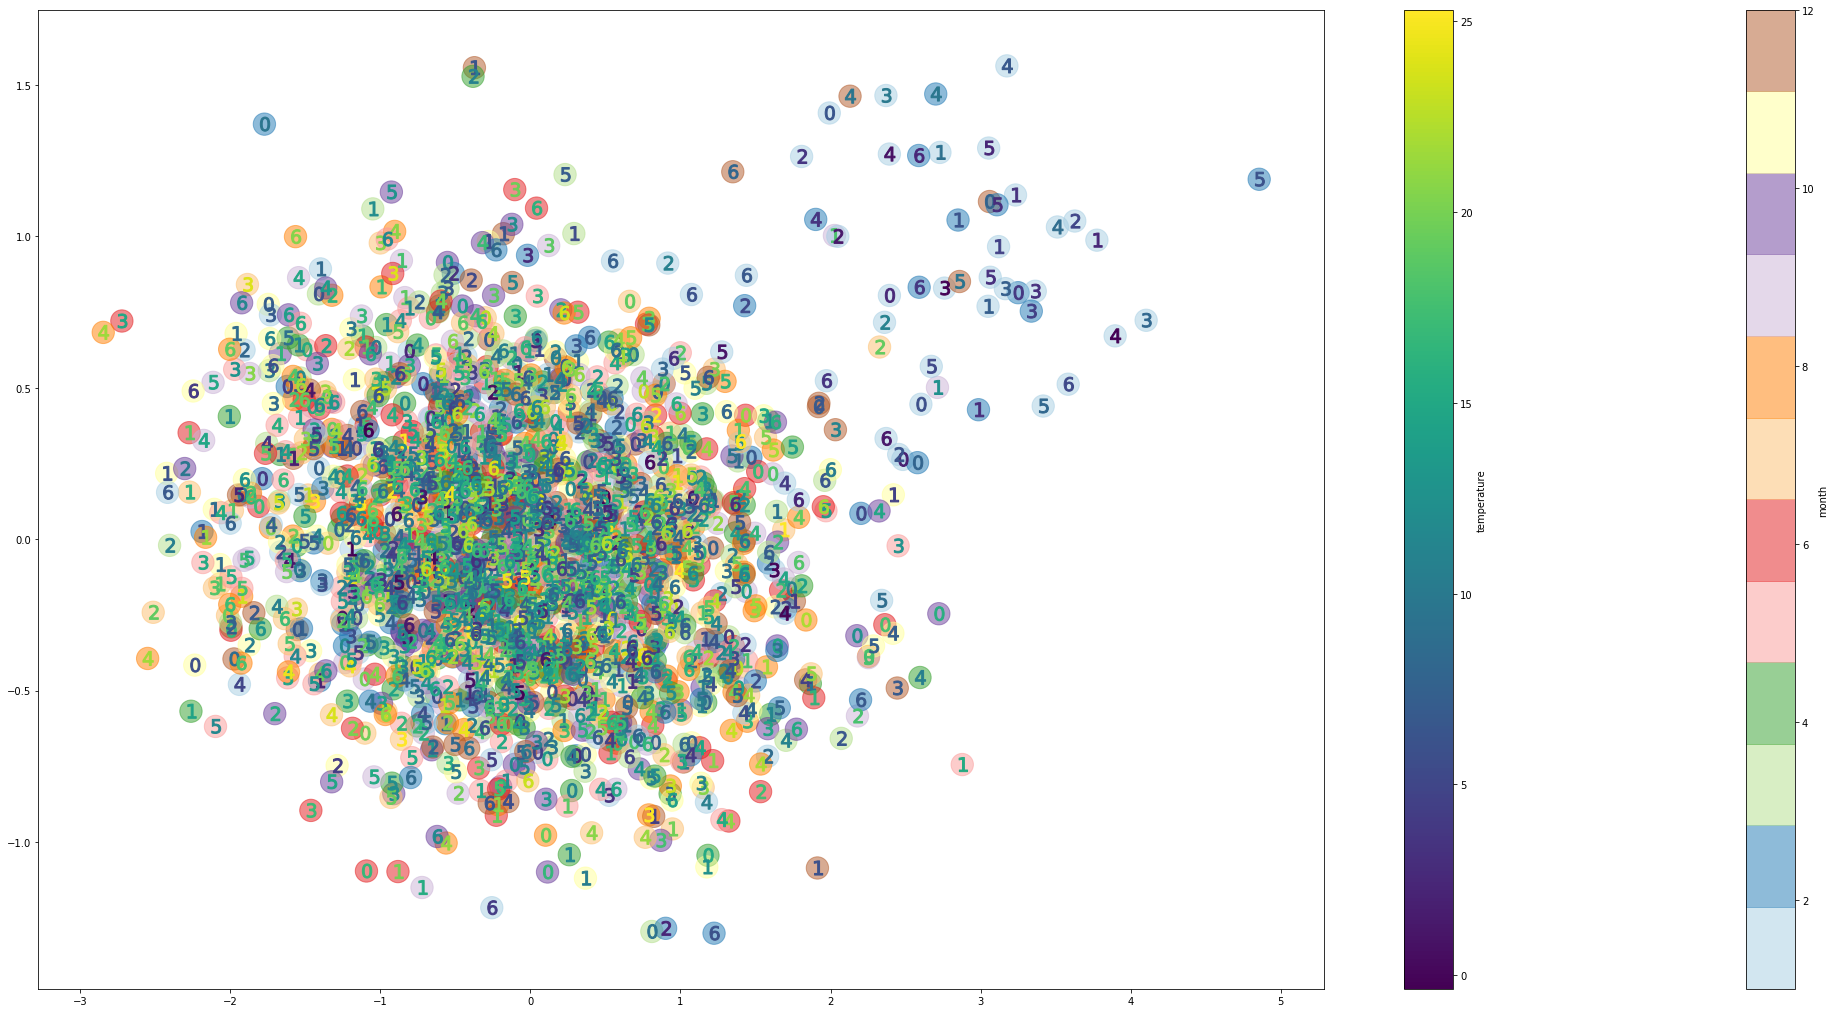

In [343]:
from sklearn.mixture import GaussianMixture
GM_H = GaussianMixture(n_components=2, n_init=100, means_init = np.r_[mean_H.reshape(1,-1), mean_N.reshape(1,-1)], weights_init=np.array([0.02,0.98]), random_state=42)
GM_H.fit(x_train_encoded_cvae)

prez_2D(GM_H.sample(n_samples=nPoints)[0], factorMatrix['train'])

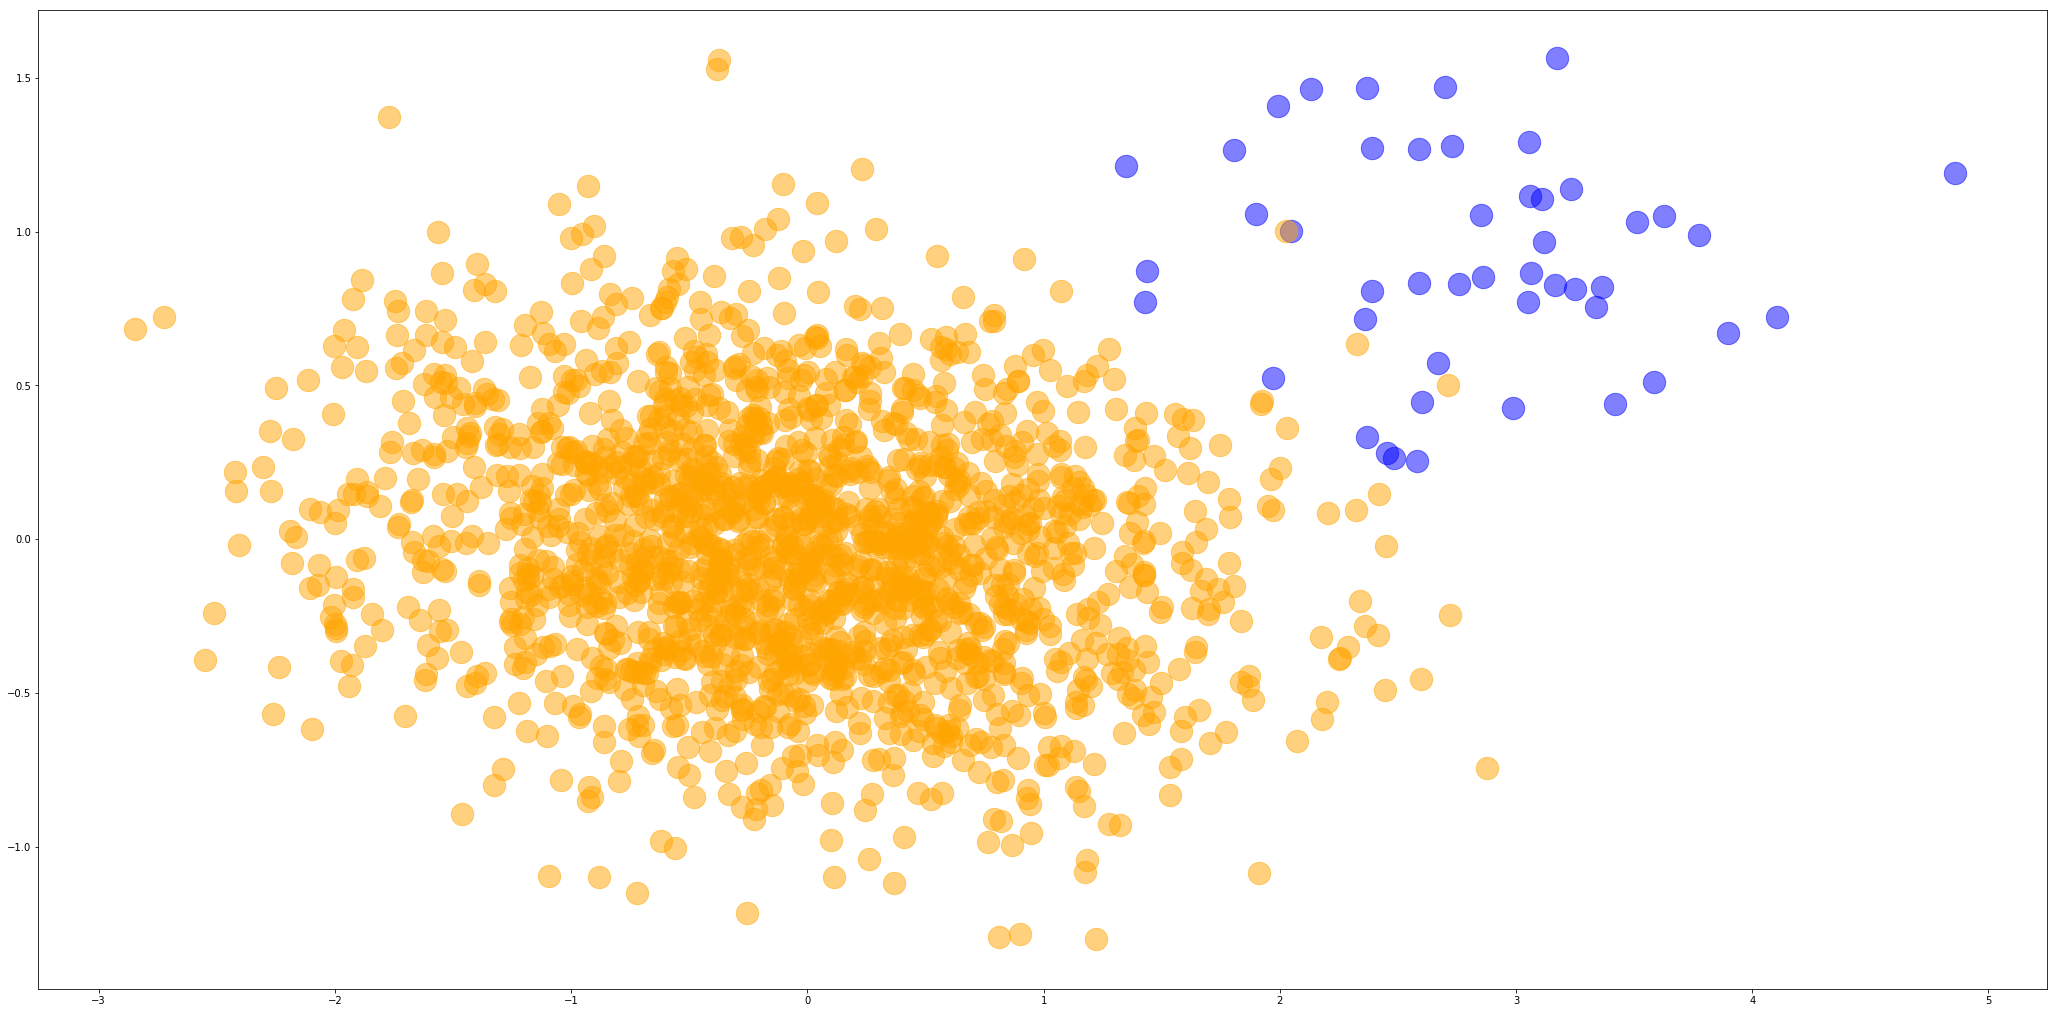

In [344]:
colors = ['blue', 'orange', 'green']
test_GM = GM_H.sample(n_samples=nPoints)
proj2D = PCA(2)
proj = proj2D.fit_transform(test_GM[0])
plt.figure(figsize=(36,18))
    
#visualisation des mois par un disque de fond coloré
for i in np.unique(test_GM[1]):
    i = int(i)
    index = test_GM[1]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= colors[i], marker = 'o', s=500, alpha=0.5)


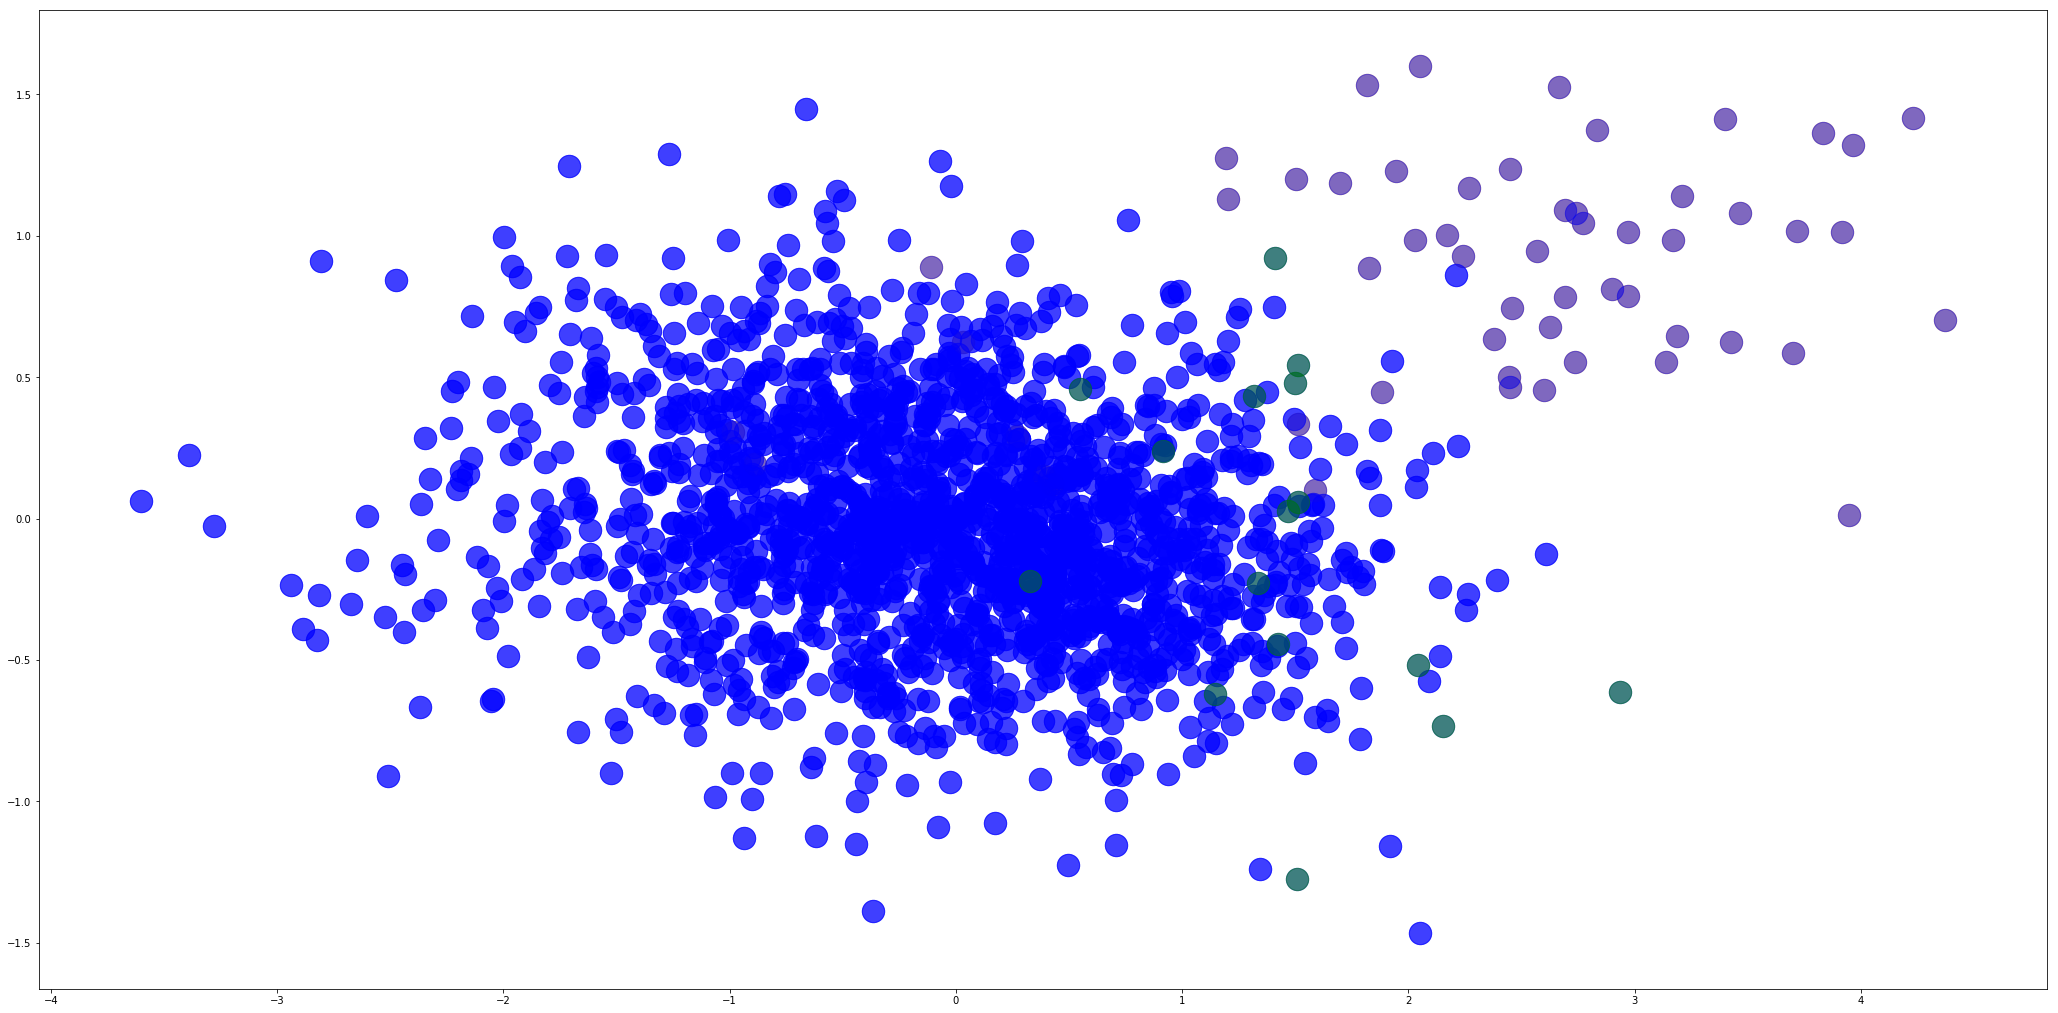

In [345]:
colors = ['blue', 'orange', 'green']
proj2D = PCA(2)
proj = proj2D.fit_transform(x_train_encoded_cvae)
plt.figure(figsize=(36,18))
    
#visualisation des mois par un disque de fond coloré
for i in np.unique(factorMatrix['train'][:,3]):
    i = int(i)
    index = factorMatrix['train'][:,3]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= colors[i], marker = 'o', s=500, alpha=0.5)
for i in np.unique(factorMatrix['train'][:,4]):
    i = int(i)
    index = factorMatrix['train'][:,4]==i
    plt.scatter(x=proj[index,0], y=proj[index,1], c= colors[2*i], marker = 'o', s=500, alpha=0.5)

## Récupération des prédiction J-1

In [184]:
dict_xconso_J1= dict_xconso.copy()
for key in ['train', 'test']:
    dict_xconso_J1[key]['consumption_France_final']=dict_xconso_J1[key].day_ahead.values

In [185]:
dataset_j1 = get_dataset_autoencoder(dict_xconso=dict_xconso_J1)

### Définition de quelques distances et mesures pour la recherche des profils

In [186]:
KL_div = KL_distance(prior='Gaussian')

In [251]:
def KNN_pred(dataset,ids,dist,**kwargs):
    neighbors_x = dataset[ids,:]
    w = 1/dist / sum(1/dist)
    weights = np.tile(w.reshape(-1,1),(1,48))
    
    return np.sum(weights*neighbors_x,axis=0)
    
    

In [244]:
def l1_loss(y_true,y_pred,scaler=None):
    if scaler is not None:
        y_true = scaler.inverse_transform(y_true)
        y_pred = scaler.inverse_transform(y_pred)

    return np.sum(np.abs(y_true-y_pred))

def mape(y_true,y_pred, scaler=None):
    if scaler is not None:
        y_true = scaler.inverse_transform(y_true)
        y_pred = scaler.inverse_transform(y_pred)
    return np.sum(np.abs((y_true-y_pred)/y_true))/48*100

Fonction pour transformer les conditions considérées à un indice et retourner un dictionnaire desdites conditions sélectionnées

In [457]:
def set_search(indice, factorMatrix, factorDesc, guided=False):
    search = {}
    keys = [key for key in factorDesc.keys()]
    if factorMatrix[indice,3]==0: #Je regarde si c'est un jour férié
        search.update({keys[2]:factorMatrix[indice,2]}) #condition jour de weekend ou non
        search.update({keys[-1]:factorMatrix[indice,6]}) #condition de température
        #search.update({keys[-2]:factorMatrix[indice,5]}) #condition de saison
        search.update({keys[0]:factorMatrix[indice,0]}) #condition de mois

    else:
        search.update({keys[2]:factorMatrix[indice,2]})
        #search.update({keys[-1]:factorMatrix[indice,6]})
        search.update({keys[-2]:factorMatrix[indice,5]})
        search.update({keys[3]:factorMatrix[indice,3]})
        search.update({keys[0]:factorMatrix[indice,0]})
    
    if guided:
        #search.update({keys[0]:factorMatrix[indice,0]})
        search.update({keys[1]:factorMatrix[indice,1]}) #condition du jour de la semaine
    return search

# Test de la prédiction

dict_items([('is_weekday', 1.0), ('temperature', 20.55116204833652)])
2 out of 3 neighbors whithin the radius limitation
3 out of 3 neighbors whithin the radius limitation
3 out of 3 neighbors whithin the radius limitation
237    2013-08-22
1314   2016-08-03
Name: ds, dtype: datetime64[ns]
1313   2016-08-02
1314   2016-08-03
237    2013-08-22
Name: ds, dtype: datetime64[ns]
1314   2016-08-03
1328   2016-08-17
237    2013-08-22
Name: ds, dtype: datetime64[ns]
mae : info =9.613095053838816, mode=10.179847614315769, guided=10.119496992766129, j-1=2.1065773019242053
mae : info =2400.8088180612576, mode=2542.3516341086774, guided=2527.2794535486814, j-1=526.1041666666666
mape (%) : info =5.1469033883989495, mode=5.460423915847427, guided=5.4081485785997785, j-1=1.1174651671449571


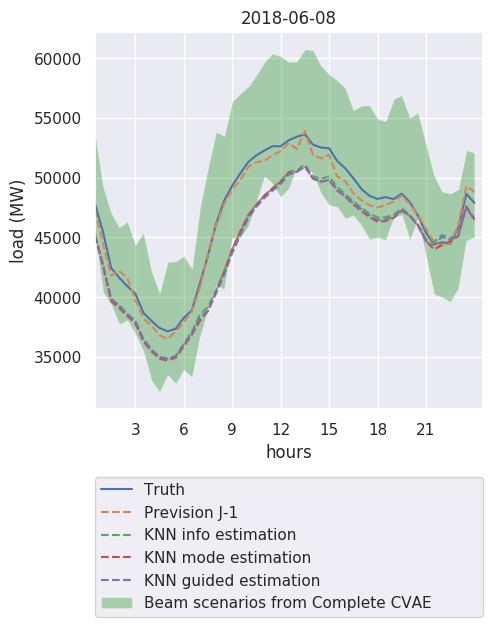

In [464]:
indice=158
metric=KL_div.pairwise #metric
q_alpha = 0.01 #quantile de limites du faisceau de scénario
n_neighbors=3 #le nombre de plus proches voisins que l'on regarde pour la moyenne pondérée
radius=2 #seuil pour comptabiliser le plus proche voisin, multiplicateur de la plus petite distance

#On récupère les conditions du profil
k=5000
cond_ind = dataset_cond['test']['x'][1][indice,:]
cond = np.tile(cond_ind.reshape(1,-1),(k,1))
is_H = calendar_info['test']['is_holiday_day'].iloc[indice]

#On échantillonne sur la partie de la projection correpsondant au statut de jour férié ou non, avec réitération tant que nombre < k.
z_coord= np.zeros((1,2))

for step in range(10000):
    if is_H ==1:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==0)[0]
        samples=samples[target,:]
    else:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==1)[0]
        samples=samples[target,:]
        
    z_coord=np.r_[z_coord, samples]
    
    if z_coord.shape[0]>(k+1):
        z_coord = z_coord[1:(k+1),:]
        break

#Vrai profil
x = dataset_guided['test']['y'][indice,:]
#prevision à J-1
x_j_1 = dataset_j1['test']['x'][0][indice,:]

#prevision du CVAE
x_hat = model_cvae_all_cond.decoder.predict([z_coord,cond])

rescaled_x_hat = scaler.inverse_transform(x_hat)

scenario_inf = np.quantile(rescaled_x_hat,q_alpha,axis=0) 
scenario_sup = np.quantile(rescaled_x_hat,1-q_alpha,axis=0) 

#Mise en forme du dictionnaire de conditions pour chercher les coordonnées dans l'espace latent
search=set_search(indice, factorMatrix['test'], factorDesc)

print(search.items())

search_id_info, dist_info, center_info = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_info, variances=variance_train_info, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_mode, dist_mode, center_mode = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_mode, variances=variance_train_mode, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_guided, dist_guided, center_guided = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_guided, variances=variance_train_guided, metric='minkowski', n_neighbors=n_neighbors, return_center=True, radius=2)
#Calcul de la moyenne pondérée des plus proches profils
x_hat_info= KNN_pred(dataset['train']['x'][0], search_id_info, dist_info)
x_hat_mode= KNN_pred(dataset['train']['x'][0], search_id_mode, dist_mode)
x_hat_guided= KNN_pred(dataset['train']['x'][0], search_id_guided, dist_guided)

#Représentation des courbes et de l'amplitude des scénarios issus du CVAE
display_loads(list_x=[x, x_j_1, x_hat_info, x_hat_mode, x_hat_guided],scaler=scaler,labels=['Truth', 'Prevision J-1', 'KNN info estimation', 'KNN mode estimation', 'KNN guided estimation'], date = calendar_info['test'].ds.dt.date[indice].isoformat())
plt.grid()
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Beam scenarios from Complete CVAE');
plt.legend(bbox_to_anchor=(0.0, -0.55, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);

#Informations sur les plus proches voisins et l'erreur de prédiction
print(calendar_info['train'].ds.iloc[search_id_info])
print(calendar_info['train'].ds.iloc[search_id_mode])
print(calendar_info['train'].ds.iloc[search_id_guided])

print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info),l1_loss(x, x_hat_mode),l1_loss(x, x_hat_guided),l1_loss(x,x_j_1)))
print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info,scaler)/48,l1_loss(x, x_hat_mode,scaler)/48,l1_loss(x, x_hat_guided,scaler)/48,l1_loss(x,x_j_1,scaler)/48))
print('mape (%) : info ={}, mode={}, guided={}, j-1={}'.format(mape(x, x_hat_info,scaler),mape(x, x_hat_mode,scaler),mape(x, x_hat_guided,scaler),mape(x,x_j_1,scaler)))

dict_items([('is_weekday', 1.0), ('temperature', 17.802099612011858)])
1 out of 5 neighbors whithin the radius limitation
5 out of 5 neighbors whithin the radius limitation
5 out of 5 neighbors whithin the radius limitation
1256   2016-06-06
Name: ds, dtype: datetime64[ns]
1708   2017-09-01
970    2015-08-25
609    2014-08-29
242    2013-08-27
978    2015-09-02
Name: ds, dtype: datetime64[ns]
1734   2017-09-27
1363   2016-09-21
1369   2016-09-27
1364   2016-09-22
1371   2016-09-29
Name: ds, dtype: datetime64[ns]
mae : info =5.321124339094018, mode=3.364775456999583, guided=3.724587244772956, j-1=1.2140785669902543
mae : info =1328.9166666666667, mode=840.3310840804412, guided=930.1917697483462, j-1=303.2083333333333
mape (%) : info =2.960693768845743, mode=1.8013201772677563, guided=1.9447538608780377, j-1=0.6544755776808961


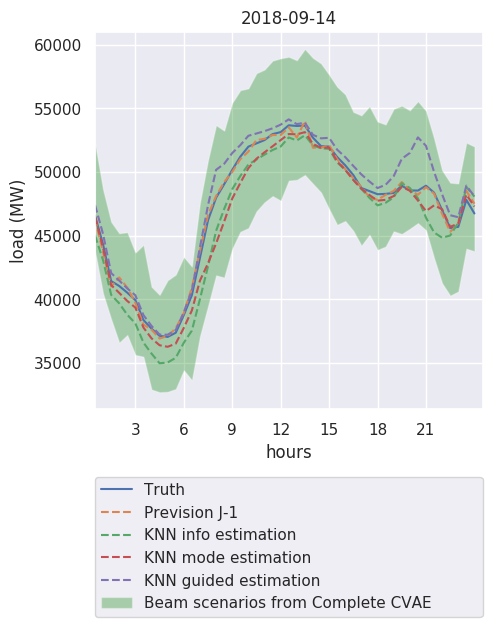

In [465]:
indice=256
metric=KL_div.pairwise #metric
q_alpha = 0.01 #quantile de limites du faisceau de scénario
n_neighbors=3 #le nombre de plus proches voisins que l'on regarde pour la moyenne pondérée
radius=2 #seuil pour comptabiliser le plus proche voisin, multiplicateur de la plus petite distance

#On récupère les conditions du profil
k=5000
cond_ind = dataset_cond['test']['x'][1][indice,:]
cond = np.tile(cond_ind.reshape(1,-1),(k,1))
is_H = calendar_info['test']['is_holiday_day'].iloc[indice]

#On échantillonne sur la partie de la projection correpsondant au statut de jour férié ou non, avec réitération tant que nombre < k.
z_coord= np.zeros((1,2))

for step in range(10000):
    if is_H ==1:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==0)[0]
        samples=samples[target,:]
    else:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==1)[0]
        samples=samples[target,:]
        
    z_coord=np.r_[z_coord, samples]
    
    if z_coord.shape[0]>(k+1):
        z_coord = z_coord[1:(k+1),:]
        break

#Vrai profil
x = dataset_guided['test']['y'][indice,:]
#prevision à J-1
x_j_1 = dataset_j1['test']['x'][0][indice,:]

#prevision du CVAE
x_hat = model_cvae_all_cond.decoder.predict([z_coord,cond])

rescaled_x_hat = scaler.inverse_transform(x_hat)

scenario_inf = np.quantile(rescaled_x_hat,q_alpha,axis=0) 
scenario_sup = np.quantile(rescaled_x_hat,1-q_alpha,axis=0) 

#Mise en forme du dictionnaire de conditions pour chercher les coordonnées dans l'espace latent
search=set_search(indice, factorMatrix['test'], factorDesc)

print(search.items())

search_id_info, dist_info, center_info = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_info, variances=variance_train_info, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_mode, dist_mode, center_mode = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_mode, variances=variance_train_mode, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_guided, dist_guided, center_guided = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_guided, variances=variance_train_guided, metric='minkowski', n_neighbors=n_neighbors, return_center=True, radius=2)
#Calcul de la moyenne pondérée des plus proches profils
x_hat_info= KNN_pred(dataset['train']['x'][0], search_id_info, dist_info)
x_hat_mode= KNN_pred(dataset['train']['x'][0], search_id_mode, dist_mode)
x_hat_guided= KNN_pred(dataset['train']['x'][0], search_id_guided, dist_guided)

#Représentation des courbes et de l'amplitude des scénarios issus du CVAE
display_loads(list_x=[x, x_j_1, x_hat_info, x_hat_mode, x_hat_guided],scaler=scaler,labels=['Truth', 'Prevision J-1', 'KNN info estimation', 'KNN mode estimation', 'KNN guided estimation'], date = calendar_info['test'].ds.dt.date[indice].isoformat())
plt.grid()
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Beam scenarios from Complete CVAE');
plt.legend(bbox_to_anchor=(0.0, -0.55, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);

#Informations sur les plus proches voisins et l'erreur de prédiction
print(calendar_info['train'].ds.iloc[search_id_info])
print(calendar_info['train'].ds.iloc[search_id_mode])
print(calendar_info['train'].ds.iloc[search_id_guided])

print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info),l1_loss(x, x_hat_mode),l1_loss(x, x_hat_guided),l1_loss(x,x_j_1)))
print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info,scaler)/48,l1_loss(x, x_hat_mode,scaler)/48,l1_loss(x, x_hat_guided,scaler)/48,l1_loss(x,x_j_1,scaler)/48))
print('mape (%) : info ={}, mode={}, guided={}, j-1={}'.format(mape(x, x_hat_info,scaler),mape(x, x_hat_mode,scaler),mape(x, x_hat_guided,scaler),mape(x,x_j_1,scaler)))

dict_items([('is_weekday', 1.0), ('temperature', 6.049047605446003)])
3 out of 5 neighbors whithin the radius limitation
1 out of 5 neighbors whithin the radius limitation
5 out of 5 neighbors whithin the radius limitation
1103   2016-01-05
356    2013-12-19
717    2014-12-15
Name: ds, dtype: datetime64[ns]
1103   2016-01-05
Name: ds, dtype: datetime64[ns]
339    2013-12-02
745    2015-01-12
1123   2016-01-25
1081   2015-12-14
787    2015-02-23
Name: ds, dtype: datetime64[ns]
mae : info =20.298078642422126, mode=19.338835098819338, guided=24.50208162719763, j-1=4.348877142565819
mae : info =5069.314921105223, mode=4829.75, guided=6119.23769628619, j-1=1086.1041666666667
mape (%) : info =7.977294207612413, mode=7.589852155543077, guided=9.704071299683708, j-1=1.6980545449924782


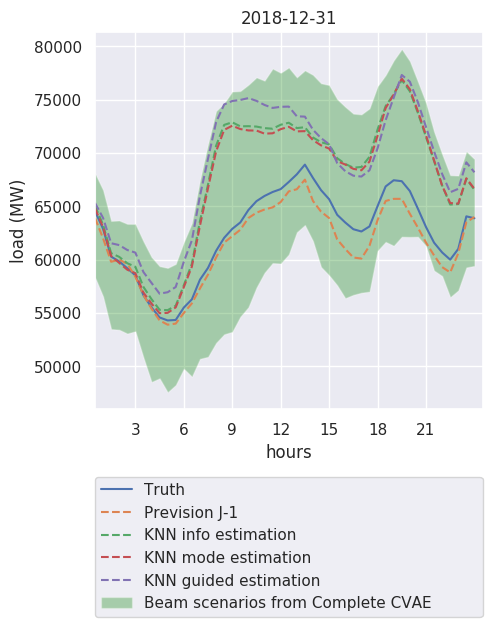

In [466]:
indice=364
metric=KL_div.pairwise #metric
q_alpha = 0.01 #quantile de limites du faisceau de scénario
n_neighbors=3 #le nombre de plus proches voisins que l'on regarde pour la moyenne pondérée
radius=2 #seuil pour comptabiliser le plus proche voisin, multiplicateur de la plus petite distance

#On récupère les conditions du profil
k=5000
cond_ind = dataset_cond['test']['x'][1][indice,:]
cond = np.tile(cond_ind.reshape(1,-1),(k,1))
is_H = calendar_info['test']['is_holiday_day'].iloc[indice]

#On échantillonne sur la partie de la projection correpsondant au statut de jour férié ou non, avec réitération tant que nombre < k.
z_coord= np.zeros((1,2))

for step in range(10000):
    if is_H ==1:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==0)[0]
        samples=samples[target,:]
    else:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==1)[0]
        samples=samples[target,:]
        
    z_coord=np.r_[z_coord, samples]
    
    if z_coord.shape[0]>(k+1):
        z_coord = z_coord[1:(k+1),:]
        break

#Vrai profil
x = dataset_guided['test']['y'][indice,:]
#prevision à J-1
x_j_1 = dataset_j1['test']['x'][0][indice,:]

#prevision du CVAE
x_hat = model_cvae_all_cond.decoder.predict([z_coord,cond])

rescaled_x_hat = scaler.inverse_transform(x_hat)

scenario_inf = np.quantile(rescaled_x_hat,q_alpha,axis=0) 
scenario_sup = np.quantile(rescaled_x_hat,1-q_alpha,axis=0) 

#Mise en forme du dictionnaire de conditions pour chercher les coordonnées dans l'espace latent
search=set_search(indice, factorMatrix['test'], factorDesc)

print(search.items())

search_id_info, dist_info, center_info = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_info, variances=variance_train_info, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_mode, dist_mode, center_mode = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_mode, variances=variance_train_mode, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_guided, dist_guided, center_guided = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_guided, variances=variance_train_guided, metric='minkowski', n_neighbors=n_neighbors, return_center=True, radius=2)
#Calcul de la moyenne pondérée des plus proches profils
x_hat_info= KNN_pred(dataset['train']['x'][0], search_id_info, dist_info)
x_hat_mode= KNN_pred(dataset['train']['x'][0], search_id_mode, dist_mode)
x_hat_guided= KNN_pred(dataset['train']['x'][0], search_id_guided, dist_guided)

#Représentation des courbes et de l'amplitude des scénarios issus du CVAE
display_loads(list_x=[x, x_j_1, x_hat_info, x_hat_mode, x_hat_guided],scaler=scaler,labels=['Truth', 'Prevision J-1', 'KNN info estimation', 'KNN mode estimation', 'KNN guided estimation'], date = calendar_info['test'].ds.dt.date[indice].isoformat())
plt.grid()
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Beam scenarios from Complete CVAE');
plt.legend(bbox_to_anchor=(0.0, -0.55, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);

#Informations sur les plus proches voisins et l'erreur de prédiction
print(calendar_info['train'].ds.iloc[search_id_info])
print(calendar_info['train'].ds.iloc[search_id_mode])
print(calendar_info['train'].ds.iloc[search_id_guided])

print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info),l1_loss(x, x_hat_mode),l1_loss(x, x_hat_guided),l1_loss(x,x_j_1)))
print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info,scaler)/48,l1_loss(x, x_hat_mode,scaler)/48,l1_loss(x, x_hat_guided,scaler)/48,l1_loss(x,x_j_1,scaler)/48))
print('mape (%) : info ={}, mode={}, guided={}, j-1={}'.format(mape(x, x_hat_info,scaler),mape(x, x_hat_mode,scaler),mape(x, x_hat_guided,scaler),mape(x,x_j_1,scaler)))

dict_items([('is_weekday', 0.0), ('season', 1.0), ('is_holiday_day', 1.0), ('month', 11.0)])
1 out of 5 neighbors whithin the radius limitation
1 out of 5 neighbors whithin the radius limitation
5 out of 5 neighbors whithin the radius limitation
861   2015-05-08
Name: ds, dtype: datetime64[ns]
861   2015-05-08
Name: ds, dtype: datetime64[ns]
1402   2016-10-30
1597   2017-05-13
876    2015-05-23
498    2014-05-10
855    2015-05-02
Name: ds, dtype: datetime64[ns]
mae : info =24.229517950647335, mode=24.229517950647335, guided=17.256403689416373, j-1=6.021008850365712
mae : info =6051.166666666667, mode=6051.166666666667, guided=4309.676115085494, j-1=1503.7083333333333
mape (%) : info =12.303467284725844, mode=12.303467284725844, guided=8.734901907100912, j-1=3.0441136364950436


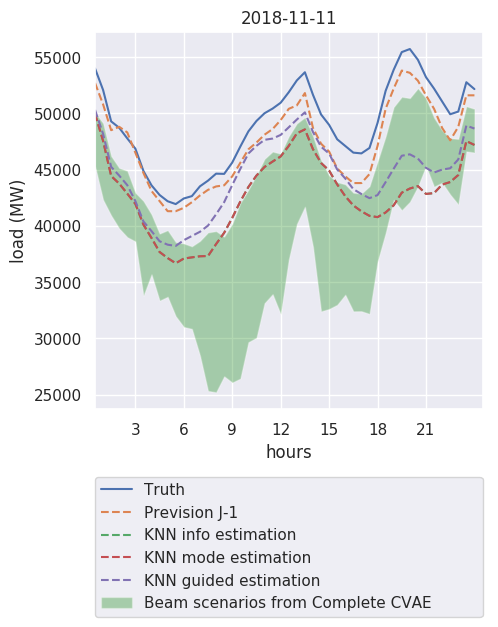

In [467]:
indice=314
metric=KL_div.pairwise #metric
q_alpha = 0.01 #quantile de limites du faisceau de scénario
n_neighbors=3 #le nombre de plus proches voisins que l'on regarde pour la moyenne pondérée
radius=2 #seuil pour comptabiliser le plus proche voisin, multiplicateur de la plus petite distance

#On récupère les conditions du profil
k=5000
cond_ind = dataset_cond['test']['x'][1][indice,:]
cond = np.tile(cond_ind.reshape(1,-1),(k,1))
is_H = calendar_info['test']['is_holiday_day'].iloc[indice]

#On échantillonne sur la partie de la projection correpsondant au statut de jour férié ou non, avec réitération tant que nombre < k.
z_coord= np.zeros((1,2))

for step in range(10000):
    if is_H ==1:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==0)[0]
        samples=samples[target,:]
    else:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==1)[0]
        samples=samples[target,:]
        
    z_coord=np.r_[z_coord, samples]
    
    if z_coord.shape[0]>(k+1):
        z_coord = z_coord[1:(k+1),:]
        break

#Vrai profil
x = dataset_guided['test']['y'][indice,:]
#prevision à J-1
x_j_1 = dataset_j1['test']['x'][0][indice,:]

#prevision du CVAE
x_hat = model_cvae_all_cond.decoder.predict([z_coord,cond])

rescaled_x_hat = scaler.inverse_transform(x_hat)

scenario_inf = np.quantile(rescaled_x_hat,q_alpha,axis=0) 
scenario_sup = np.quantile(rescaled_x_hat,1-q_alpha,axis=0) 

#Mise en forme du dictionnaire de conditions pour chercher les coordonnées dans l'espace latent
search=set_search(indice, factorMatrix['test'], factorDesc)

print(search.items())

search_id_info, dist_info, center_info = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_info, variances=variance_train_info, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_mode, dist_mode, center_mode = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_mode, variances=variance_train_mode, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_guided, dist_guided, center_guided = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_guided, variances=variance_train_guided, metric='minkowski', n_neighbors=n_neighbors, return_center=True, radius=2)
#Calcul de la moyenne pondérée des plus proches profils
x_hat_info= KNN_pred(dataset['train']['x'][0], search_id_info, dist_info)
x_hat_mode= KNN_pred(dataset['train']['x'][0], search_id_mode, dist_mode)
x_hat_guided= KNN_pred(dataset['train']['x'][0], search_id_guided, dist_guided)

#Représentation des courbes et de l'amplitude des scénarios issus du CVAE
display_loads(list_x=[x, x_j_1, x_hat_info, x_hat_mode, x_hat_guided],scaler=scaler,labels=['Truth', 'Prevision J-1', 'KNN info estimation', 'KNN mode estimation', 'KNN guided estimation'], date = calendar_info['test'].ds.dt.date[indice].isoformat())
plt.grid()
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Beam scenarios from Complete CVAE');
plt.legend(bbox_to_anchor=(0.0, -0.55, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);

#Informations sur les plus proches voisins et l'erreur de prédiction
print(calendar_info['train'].ds.iloc[search_id_info])
print(calendar_info['train'].ds.iloc[search_id_mode])
print(calendar_info['train'].ds.iloc[search_id_guided])

print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info),l1_loss(x, x_hat_mode),l1_loss(x, x_hat_guided),l1_loss(x,x_j_1)))
print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info,scaler)/48,l1_loss(x, x_hat_mode,scaler)/48,l1_loss(x, x_hat_guided,scaler)/48,l1_loss(x,x_j_1,scaler)/48))
print('mape (%) : info ={}, mode={}, guided={}, j-1={}'.format(mape(x, x_hat_info,scaler),mape(x, x_hat_mode,scaler),mape(x, x_hat_guided,scaler),mape(x,x_j_1,scaler)))

dict_items([('is_weekday', 1.0), ('season', 2.0), ('is_holiday_day', 1.0), ('month', 5.0)])
1 out of 5 neighbors whithin the radius limitation
3 out of 5 neighbors whithin the radius limitation
5 out of 5 neighbors whithin the radius limitation
1235   2016-05-16
Name: ds, dtype: datetime64[ns]
1235   2016-05-16
995    2015-09-19
1723   2017-09-16
Name: ds, dtype: datetime64[ns]
498    2014-05-10
1254   2016-06-04
883    2015-05-30
1597   2017-05-13
1268   2016-06-18
Name: ds, dtype: datetime64[ns]
mae : info =10.997029229610984, mode=10.798087192249742, guided=12.690174840756013, j-1=2.8570136622817937
mae : info =2746.4375, mode=2696.753002457326, guided=3169.2897542149894, j-1=713.5208333333334
mape (%) : info =6.001737296223421, mode=5.887280361864454, guided=6.929147452704079, j-1=1.5537658728482764


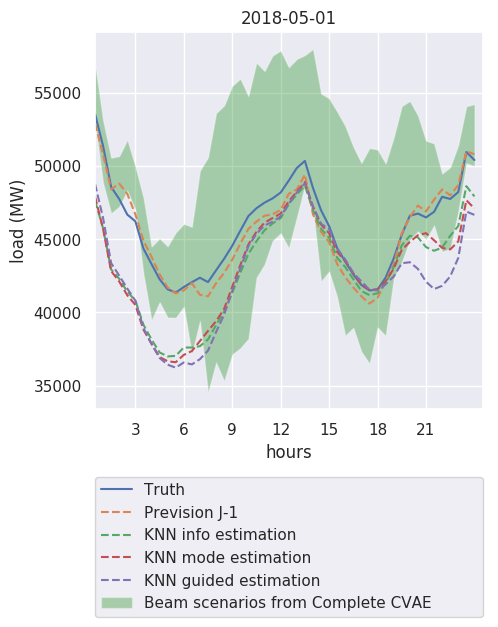

In [468]:
indice=120
metric=KL_div.pairwise #metric
q_alpha = 0.01 #quantile de limites du faisceau de scénario
n_neighbors=3 #le nombre de plus proches voisins que l'on regarde pour la moyenne pondérée
radius=2 #seuil pour comptabiliser le plus proche voisin, multiplicateur de la plus petite distance

#On récupère les conditions du profil
k=5000
cond_ind = dataset_cond['test']['x'][1][indice,:]
cond = np.tile(cond_ind.reshape(1,-1),(k,1))
is_H = calendar_info['test']['is_holiday_day'].iloc[indice]

#On échantillonne sur la partie de la projection correpsondant au statut de jour férié ou non, avec réitération tant que nombre < k.
z_coord= np.zeros((1,2))

for step in range(10000):
    if is_H ==1:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==0)[0]
        samples=samples[target,:]
    else:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==1)[0]
        samples=samples[target,:]
        
    z_coord=np.r_[z_coord, samples]
    
    if z_coord.shape[0]>(k+1):
        z_coord = z_coord[1:(k+1),:]
        break

#Vrai profil
x = dataset_guided['test']['y'][indice,:]
#prevision à J-1
x_j_1 = dataset_j1['test']['x'][0][indice,:]

#prevision du CVAE
x_hat = model_cvae_all_cond.decoder.predict([z_coord,cond])

rescaled_x_hat = scaler.inverse_transform(x_hat)

scenario_inf = np.quantile(rescaled_x_hat,q_alpha,axis=0) 
scenario_sup = np.quantile(rescaled_x_hat,1-q_alpha,axis=0) 

#Mise en forme du dictionnaire de conditions pour chercher les coordonnées dans l'espace latent
search=set_search(indice, factorMatrix['test'], factorDesc)

print(search.items())

search_id_info, dist_info, center_info = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_info, variances=variance_train_info, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_mode, dist_mode, center_mode = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_mode, variances=variance_train_mode, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_guided, dist_guided, center_guided = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_guided, variances=variance_train_guided, metric='minkowski', n_neighbors=n_neighbors, return_center=True, radius=2)
#Calcul de la moyenne pondérée des plus proches profils
x_hat_info= KNN_pred(dataset['train']['x'][0], search_id_info, dist_info)
x_hat_mode= KNN_pred(dataset['train']['x'][0], search_id_mode, dist_mode)
x_hat_guided= KNN_pred(dataset['train']['x'][0], search_id_guided, dist_guided)

#Représentation des courbes et de l'amplitude des scénarios issus du CVAE
display_loads(list_x=[x, x_j_1, x_hat_info, x_hat_mode, x_hat_guided],scaler=scaler,labels=['Truth', 'Prevision J-1', 'KNN info estimation', 'KNN mode estimation', 'KNN guided estimation'], date = calendar_info['test'].ds.dt.date[indice].isoformat())
plt.grid()
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Beam scenarios from Complete CVAE');
plt.legend(bbox_to_anchor=(0.0, -0.55, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);

#Informations sur les plus proches voisins et l'erreur de prédiction
print(calendar_info['train'].ds.iloc[search_id_info])
print(calendar_info['train'].ds.iloc[search_id_mode])
print(calendar_info['train'].ds.iloc[search_id_guided])

print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info),l1_loss(x, x_hat_mode),l1_loss(x, x_hat_guided),l1_loss(x,x_j_1)))
print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info,scaler)/48,l1_loss(x, x_hat_mode,scaler)/48,l1_loss(x, x_hat_guided,scaler)/48,l1_loss(x,x_j_1,scaler)/48))
print('mape (%) : info ={}, mode={}, guided={}, j-1={}'.format(mape(x, x_hat_info,scaler),mape(x, x_hat_mode,scaler),mape(x, x_hat_guided,scaler),mape(x,x_j_1,scaler)))

dict_items([('is_weekday', 1.0), ('temperature', 26.611647457675243)])
2 out of 5 neighbors whithin the radius limitation
1 out of 5 neighbors whithin the radius limitation
5 out of 5 neighbors whithin the radius limitation
935   2015-07-21
930   2015-07-16
Name: ds, dtype: datetime64[ns]
1635   2017-06-20
Name: ds, dtype: datetime64[ns]
1635   2017-06-20
915    2015-07-01
1636   2017-06-21
1299   2016-07-19
930    2015-07-16
Name: ds, dtype: datetime64[ns]
mae : info =2.1989891599543996, mode=3.920187452050296, guided=3.205894262534464, j-1=1.5295688198662432
mae : info =549.1834353527406, mode=979.0416666666666, guided=800.6515250456391, j-1=382.0
mape (%) : info =1.0717311316973956, mode=1.9388420371063606, guided=1.5715560871629422, j-1=0.7660120781728074


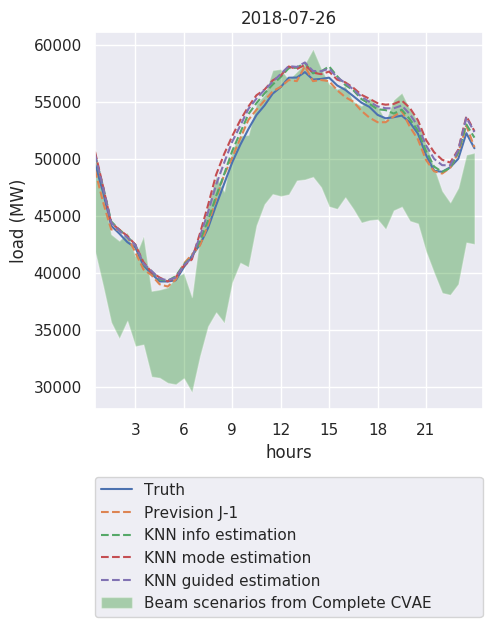

In [469]:
indice=206
metric=KL_div.pairwise #metric
q_alpha = 0.01 #quantile de limites du faisceau de scénario
n_neighbors=3 #le nombre de plus proches voisins que l'on regarde pour la moyenne pondérée
radius=2 #seuil pour comptabiliser le plus proche voisin, multiplicateur de la plus petite distance

#On récupère les conditions du profil
k=5000
cond_ind = dataset_cond['test']['x'][1][indice,:]
cond = np.tile(cond_ind.reshape(1,-1),(k,1))
is_H = calendar_info['test']['is_holiday_day'].iloc[indice]

#On échantillonne sur la partie de la projection correpsondant au statut de jour férié ou non, avec réitération tant que nombre < k.
z_coord= np.zeros((1,2))

for step in range(10000):
    if is_H ==1:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==0)[0]
        samples=samples[target,:]
    else:
        samples, labels = GM_H.sample(n_samples=10*k)
        target = np.where(labels==1)[0]
        samples=samples[target,:]
        
    z_coord=np.r_[z_coord, samples]
    
    if z_coord.shape[0]>(k+1):
        z_coord = z_coord[1:(k+1),:]
        break

#Vrai profil
x = dataset_guided['test']['y'][indice,:]
#prevision à J-1
x_j_1 = dataset_j1['test']['x'][0][indice,:]

#prevision du CVAE
x_hat = model_cvae_all_cond.decoder.predict([z_coord,cond])

rescaled_x_hat = scaler.inverse_transform(x_hat)

scenario_inf = np.quantile(rescaled_x_hat,q_alpha,axis=0) 
scenario_sup = np.quantile(rescaled_x_hat,1-q_alpha,axis=0) 

#Mise en forme du dictionnaire de conditions pour chercher les coordonnées dans l'espace latent
search=set_search(indice, factorMatrix['test'], factorDesc)

print(search.items())

search_id_info, dist_info, center_info = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_info, variances=variance_train_info, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_mode, dist_mode, center_mode = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_mode, variances=variance_train_mode, metric=metric, n_neighbors=n_neighbors, return_center=True, radius=2)

search=set_search(indice, factorMatrix['test'], factorDesc)
search_id_guided, dist_guided, center_guided = search_nearest_profiles(search, factorDesc, factorMatrix['train'], x_train_encoded_guided, variances=variance_train_guided, metric='minkowski', n_neighbors=n_neighbors, return_center=True, radius=2)
#Calcul de la moyenne pondérée des plus proches profils
x_hat_info= KNN_pred(dataset['train']['x'][0], search_id_info, dist_info)
x_hat_mode= KNN_pred(dataset['train']['x'][0], search_id_mode, dist_mode)
x_hat_guided= KNN_pred(dataset['train']['x'][0], search_id_guided, dist_guided)

#Représentation des courbes et de l'amplitude des scénarios issus du CVAE
display_loads(list_x=[x, x_j_1, x_hat_info, x_hat_mode, x_hat_guided],scaler=scaler,labels=['Truth', 'Prevision J-1', 'KNN info estimation', 'KNN mode estimation', 'KNN guided estimation'], date = calendar_info['test'].ds.dt.date[indice].isoformat())
plt.grid()
plt.fill_between(np.arange(48,step=1), scenario_inf, scenario_sup, 
                facecolor='green', alpha=0.3, label='Beam scenarios from Complete CVAE');
plt.legend(bbox_to_anchor=(0.0, -0.55, 1.0, .102), loc='lower left',
           ncol=1, mode="expand", borderaxespad=0.);

#Informations sur les plus proches voisins et l'erreur de prédiction
print(calendar_info['train'].ds.iloc[search_id_info])
print(calendar_info['train'].ds.iloc[search_id_mode])
print(calendar_info['train'].ds.iloc[search_id_guided])

print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info),l1_loss(x, x_hat_mode),l1_loss(x, x_hat_guided),l1_loss(x,x_j_1)))
print('mae : info ={}, mode={}, guided={}, j-1={}'.format(l1_loss(x, x_hat_info,scaler)/48,l1_loss(x, x_hat_mode,scaler)/48,l1_loss(x, x_hat_guided,scaler)/48,l1_loss(x,x_j_1,scaler)/48))
print('mape (%) : info ={}, mode={}, guided={}, j-1={}'.format(mape(x, x_hat_info,scaler),mape(x, x_hat_mode,scaler),mape(x, x_hat_guided,scaler),mape(x,x_j_1,scaler)))